# <center> PREDICTING THE NEXT DAY PRICE OF BITCOIN USING MACHINE LEARNING TECHNIQUES </center>
## <center> Modelling </center>
### <Center> 2148040, 2148041 </center>

## Import data & libraries

Install the following:  
   1.  `pip install xgboost`

   2.  `pip install tensorflow`

In [1]:
#For data analysis and data manipulation
import pandas as pd
import numpy as np

#To Visualise
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

#To ignore warnings
import warnings
warnings.filterwarnings("ignore")

#To find RMSE and MAE scores
import sklearn.metrics as metrics

#For modeling SVR
from sklearn.svm import SVR

#For Modelling XGBoost
import xgboost as xgb

#Shows smart progress meter
from tqdm import tqdm

#For Stochastic Gradient Descent implementation in linear regression
from sklearn.linear_model import SGDRegressor,PassiveAggressiveRegressor

#ensure that all sequences in a list have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# For modeling LSTM
from tensorflow.keras.layers import Dense,Input,Activation,Embedding,LSTM,Concatenate,Flatten,Dropout
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam 
from tensorflow.keras import callbacks,Sequential
import tensorflow as tf

#A placeholder
from tensorflow.keras import backend as K

#Used for serialization, saving objects in disks
import pickle

In [2]:
final_df = pd.read_csv('final_df_next_day.csv').reset_index(drop=True)
final_df

,Date,sma90 avg_transaction_value,closing_price,wma30 avg_transaction_value,sma90 closing_price,ema90 avg_transaction_value,dema90 avg_transaction_value,tema90 avg_transaction_value,tema30 opening_price,bband_upper90 highest_price,...,dema30 opening_price,sma30 avg_transaction_value,ema30 opening_price,dema30 lowest_price,dema7 closing_price,opening_price,wma7 closing_price,dema7 lowest_price,dema7 highest_price,next_day_closing_price
0,2013-04-01,0.000000,0.000528,0.000930,0.000000,0.000000,0.000000,0.000000,0.000259,0.000000,...,0.000027,0.000577,0.000000,0.000039,0.000449,0.000365,0.000289,0.000516,0.000391,118.0
1,2013-04-02,0.000046,0.000735,0.001088,0.000021,0.000086,0.000140,0.000197,0.000328,0.000057,...,0.000086,0.000708,0.000043,0.000096,0.000595,0.000528,0.000395,0.000589,0.000519,135.0
2,2013-04-03,0.000095,0.000987,0.001244,0.000045,0.000173,0.000279,0.000390,0.000424,0.000147,...,0.000165,0.000843,0.000098,0.000168,0.000797,0.000735,0.000544,0.000707,0.000783,132.1
3,2013-04-04,0.000140,0.000944,0.001376,0.000068,0.000252,0.000403,0.000561,0.000554,0.000222,...,0.000268,0.000946,0.000167,0.000245,0.000903,0.000987,0.000657,0.000823,0.000916,142.3
4,2013-04-05,0.000185,0.001095,0.001509,0.000094,0.000331,0.000527,0.000730,0.000658,0.000295,...,0.000356,0.001045,0.000229,0.000341,0.001033,0.000944,0.000784,0.000986,0.001012,142.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3282,2022-03-27,0.739840,0.693610,0.619036,0.735565,0.787267,0.615875,0.558641,0.654571,0.677188,...,0.636007,0.654720,0.668740,0.642882,0.693444,0.659256,0.684466,0.689081,0.675644,47105.0
3283,2022-03-28,0.741835,0.697257,0.626768,0.735478,0.789675,0.620488,0.566129,0.667327,0.674954,...,0.645810,0.661806,0.674494,0.653713,0.707165,0.693602,0.697479,0.709542,0.694065,47449.0
3284,2022-03-29,0.743503,0.702356,0.632364,0.735673,0.791334,0.623826,0.571715,0.679100,0.674958,...,0.655160,0.668538,0.680155,0.664169,0.717637,0.697560,0.708472,0.724564,0.704887,47075.0
3285,2022-03-30,0.743888,0.696812,0.631227,0.735664,0.790368,0.622848,0.571123,0.690138,0.674821,...,0.664199,0.668862,0.685789,0.672758,0.721179,0.702348,0.715236,0.730582,0.708493,45525.0


In [3]:
final_df.columns

Index(['Date', 'sma90 avg_transaction_value', 'closing_price',
       'wma30 avg_transaction_value', 'sma90 closing_price',
       'ema90 avg_transaction_value', 'dema90 avg_transaction_value',
       'tema90 avg_transaction_value', 'tema30 opening_price',
       'bband_upper90 highest_price', 'tema7 closing_price', 'lowest_price',
       'highest_price', 'bband_upper90 lowest_price', 'dema90 highest_price',
       'ema90 opening_price', 'bband_upper7 highest_price',
       'bband_upper30 closing_price', 'tema30 highest_price',
       'wma30 highest_price', 'ema30 avg_transaction_value',
       'tema30 lowest_price', 'wma90 avg_transaction_value',
       'wma90 lowest_price', 'tema7 opening_price', 'ema90 highest_price',
       'tema7 number_of_coins_in_circulation', 'dema90 closing_price',
       'sma90 opening_price', 'ema90 number_of_coins_in_circulation',
       'tema90 opening_price', 'bband_upper30 opening_price',
       'ema30 number_of_coins_in_circulation', 'tema30 closing_pri

## Defining functions for Model Evaluation Parameters and Result models

The target variable being volatile, we use Root Mean Squared error (RMSE) and Mean Absolute Error (MAE) to penalize the error. RMSE gives a relatively high weight to large errors whereas, MAE is esay to use because of it's interpretability.

In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(y, ypred):
    MAE = metrics.mean_absolute_error(y, ypred)
    RMSE = metrics.mean_squared_error(y, ypred,squared=False)
    return MAE,RMSE

def plot_results(y,ypred,title=None):
    plt.figure(figsize=(25,5))
    plt.plot(y,label='actual')
    plt.plot(ypred,label='predicted')
    plt.legend()
    plt.grid()
    plt.title(title)
    plt.show()

## Train Test Split

As the target variable is highly volatile, and avoid overfitting, we generate multiple testing and training models. Each train Split will consist of 500 data points & next 100 data points will be used for testing. Hence, prediction of the next 100 days will be based on data considered of last 500 days. The final metric will be mean over metric reported by each split.

In [5]:
train_window = 500
test_window = 100
train_splits = []
test_splits = []
for i in tqdm(range(train_window, len(final_df),test_window)):
    train_split = final_df[i-train_window:i]
    test_split = final_df[i:i+test_window]
    train_splits.append(train_split)
    test_splits.append(test_split)

100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 7027.74it/s]


In [6]:
test_split.shape

(87, 57)

In [7]:
train_split.shape

(500, 57)

In [8]:
def visualize_split(batch_no,show_plot=True):
    final_df.plot(x='Date',y='next_day_closing_price',figsize=(25,5))
    for i in range(train_splits[batch_no].index[0],train_splits[batch_no].index[-1]):
        plt.axvline(x=i,color='r',alpha=0.1)
    for i in range(test_splits[batch_no].index[0],test_splits[batch_no].index[-1]):
        plt.axvline(x=i,color='b',alpha=0.1)
    plt.grid()
    plt.legend('')
    plt.title(f'Temporal Window Split-{batch_no+1}')
    #if not os.path.exists('/content/plot'):
     #   os.makedirs('/content/plot')
        
    #plt.savefig(f'/content/plot/Temporal Window Split-{batch_no+1}.png')
    plt.show()

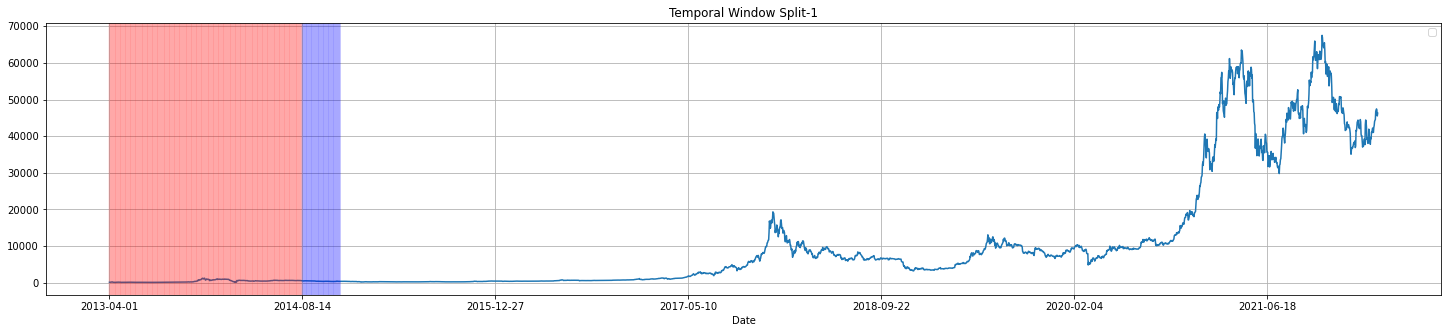

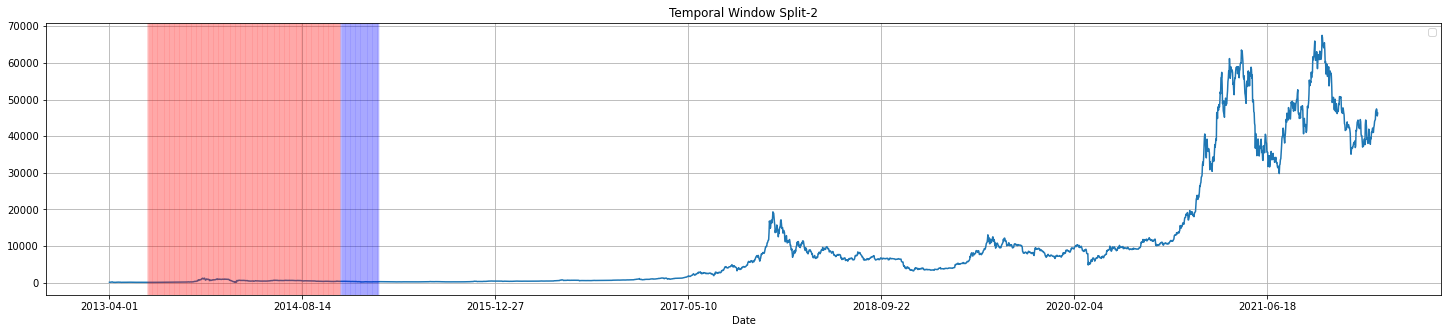

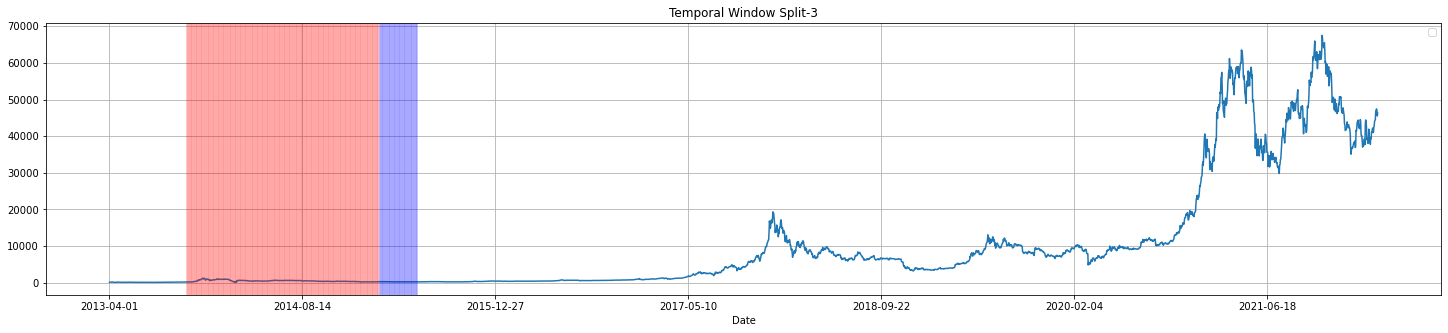

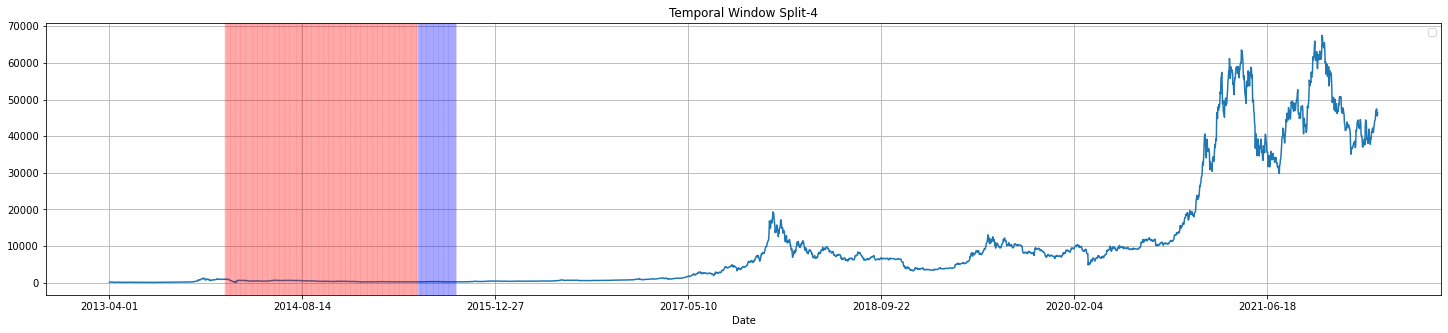

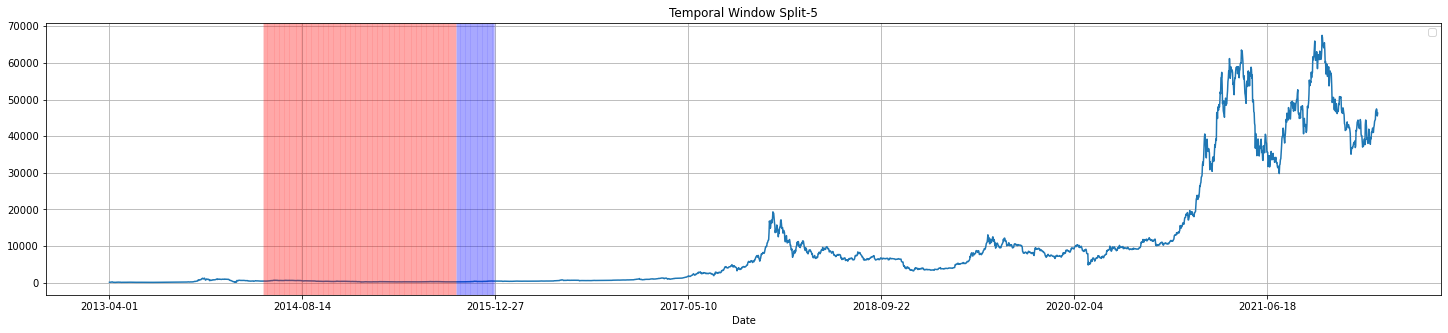

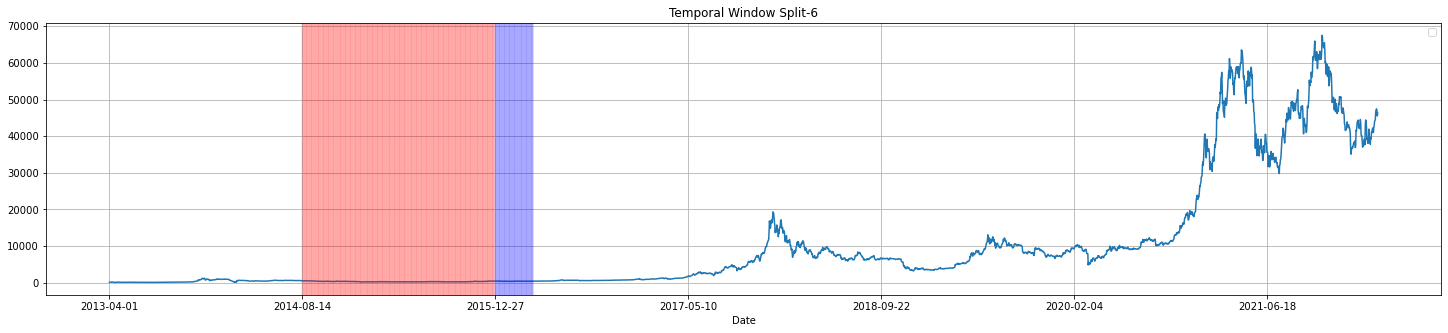

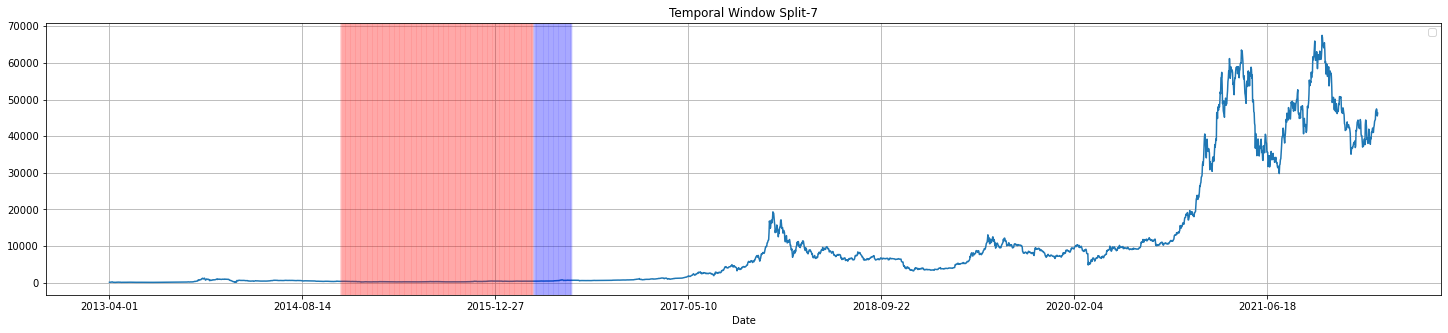

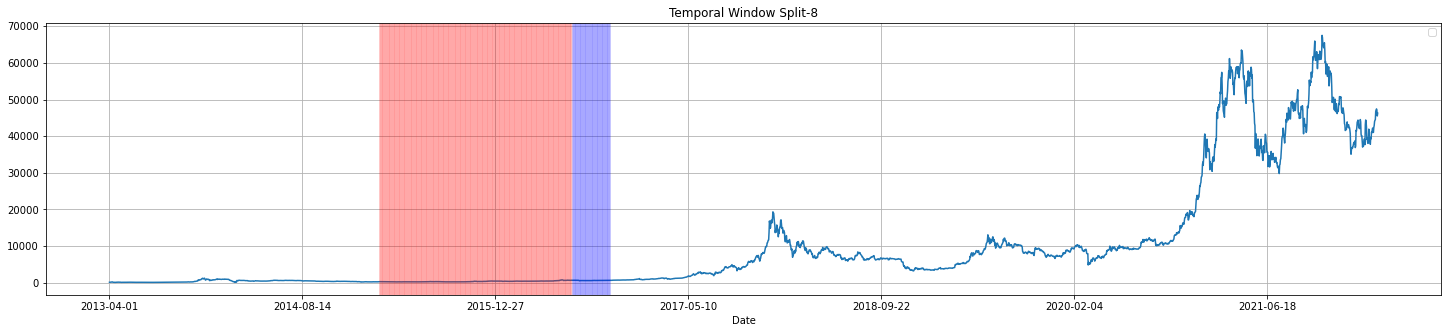

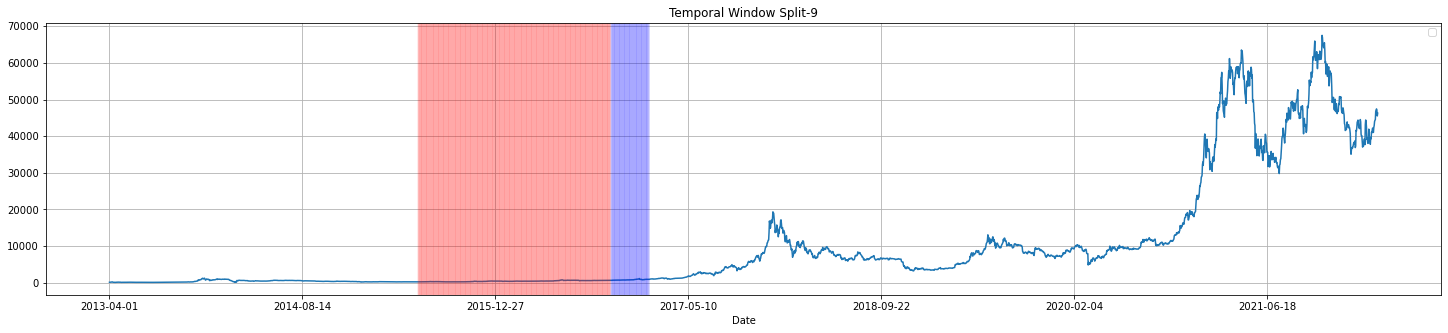

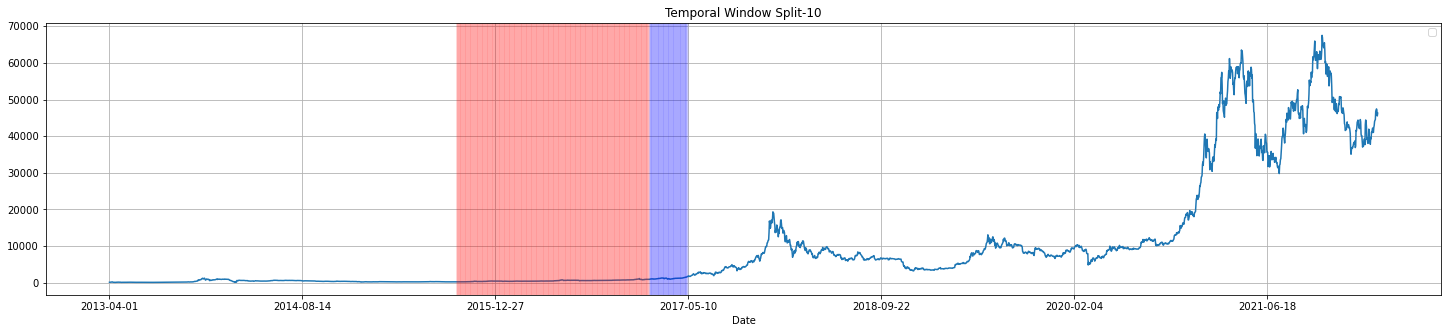

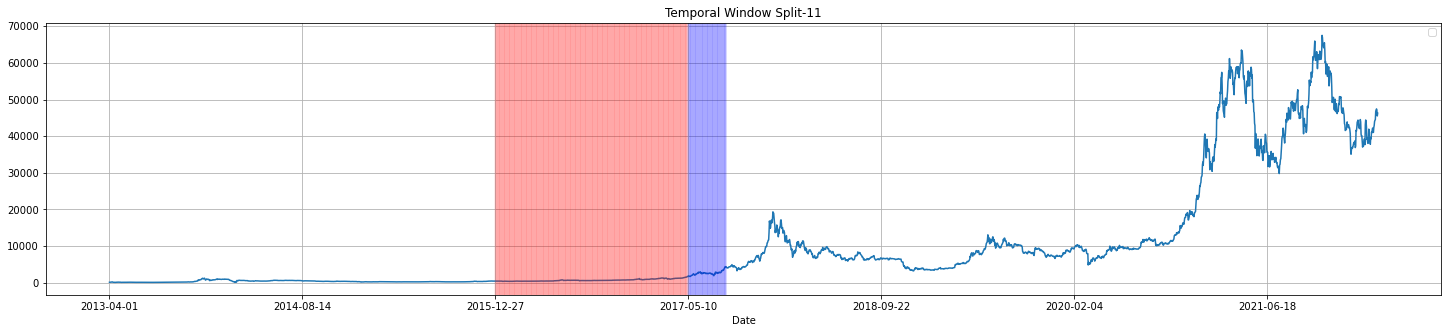

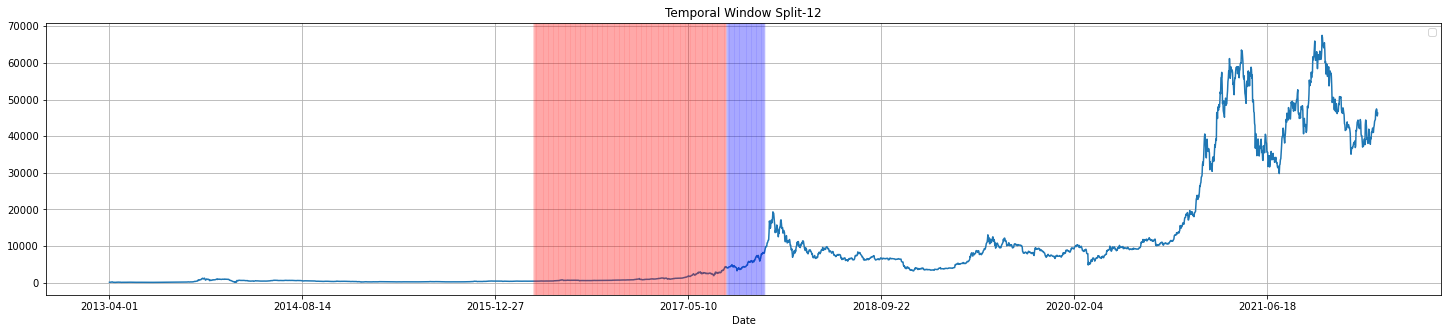

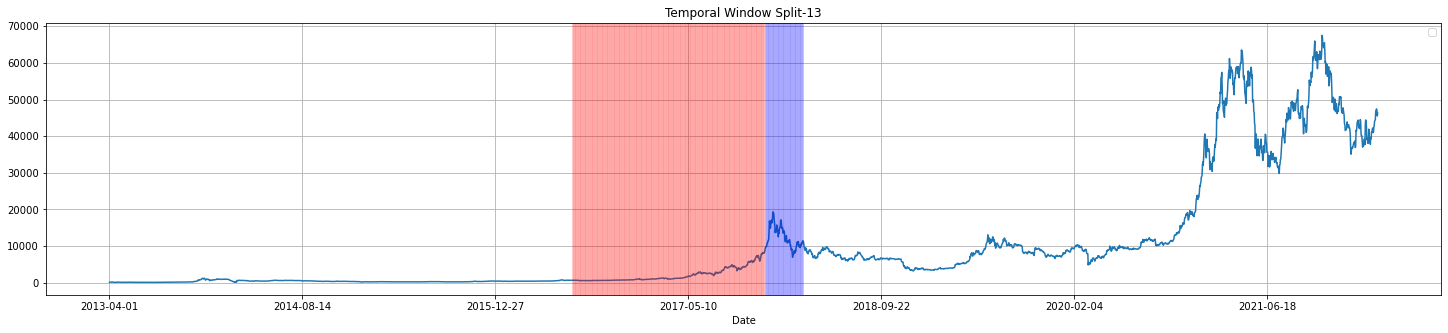

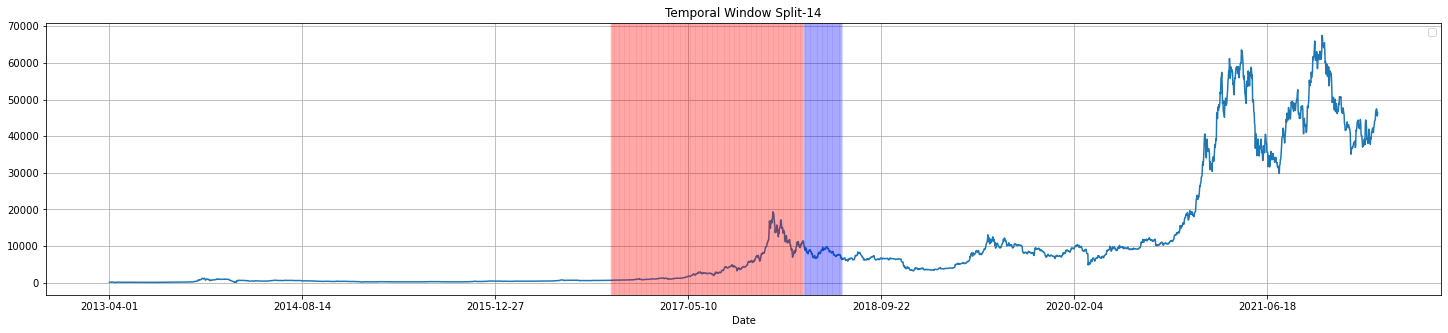

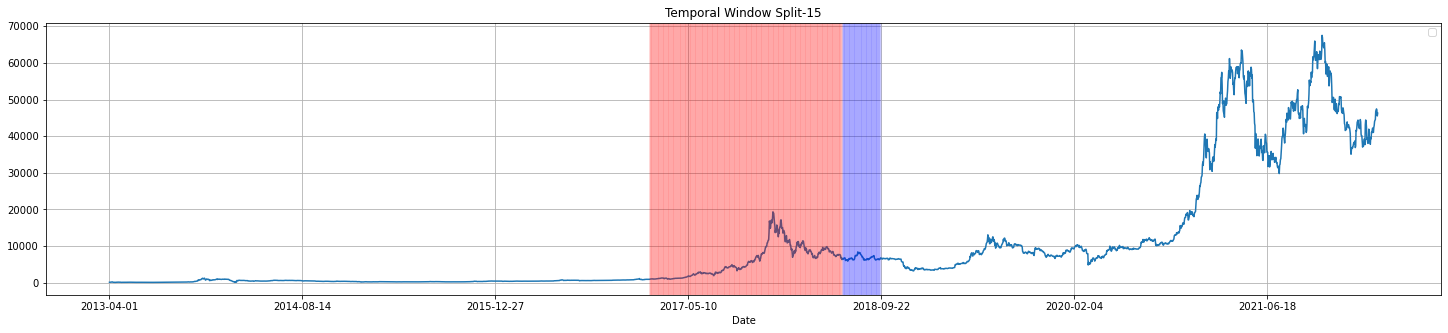

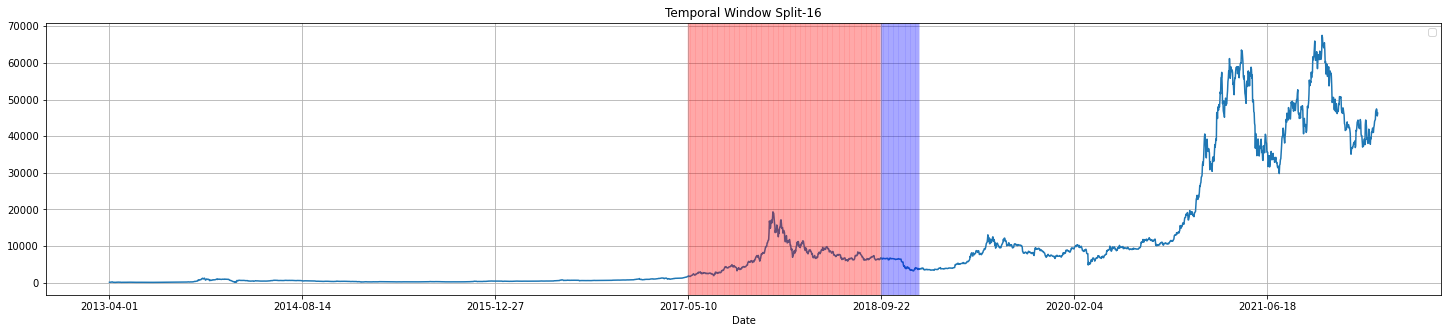

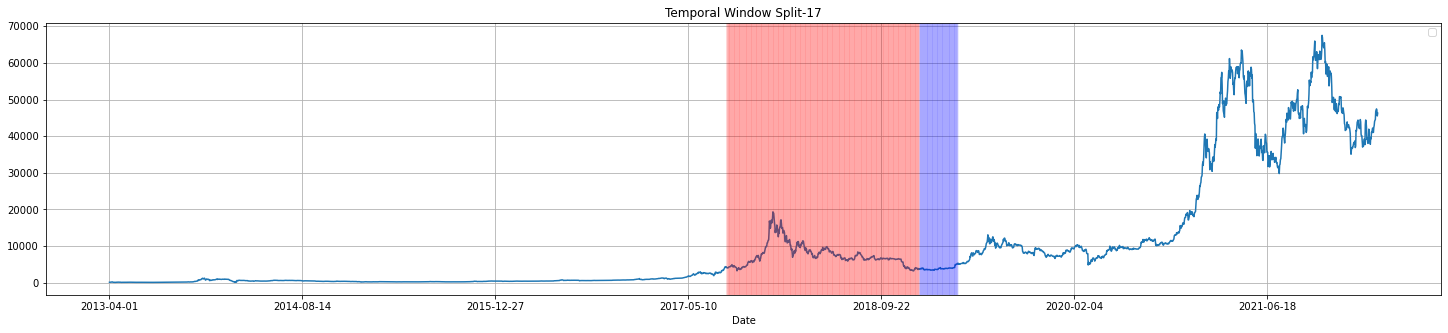

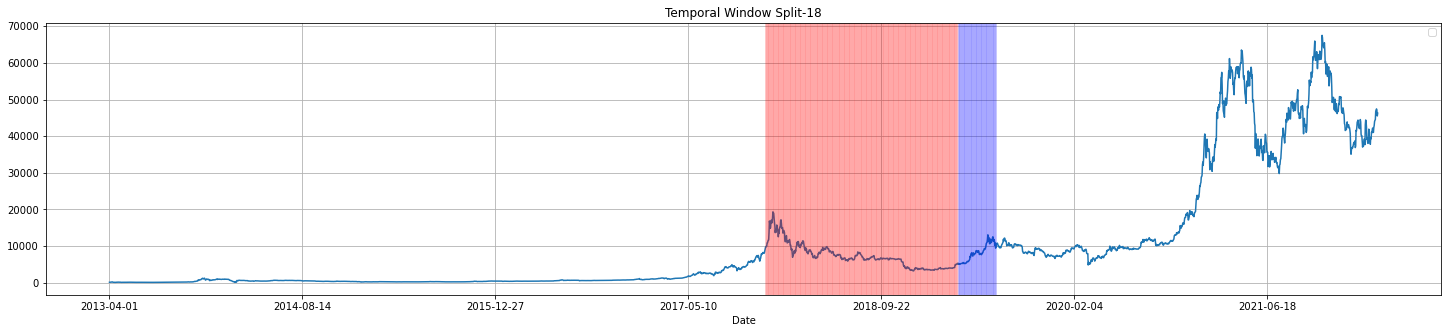

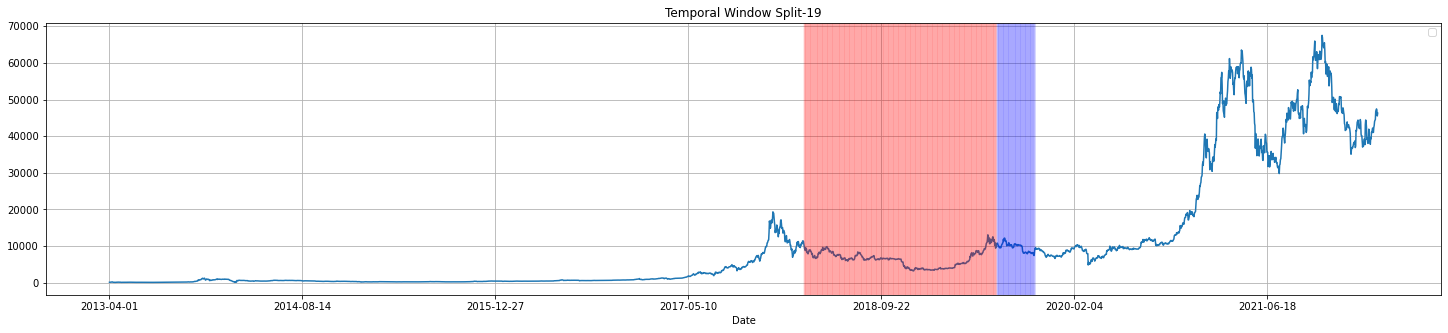

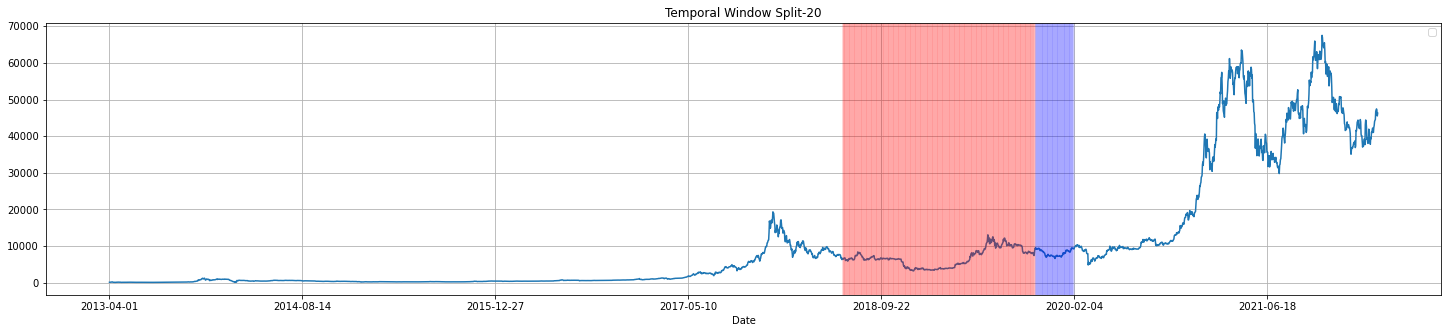

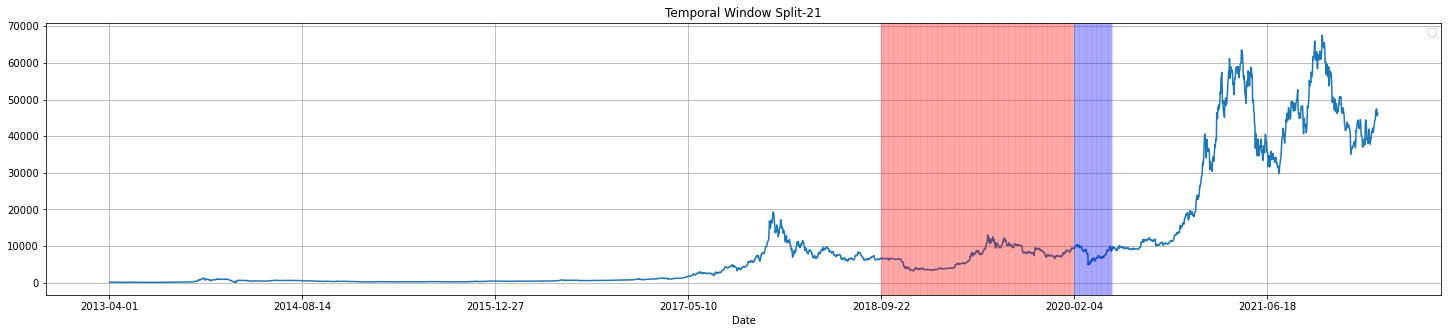

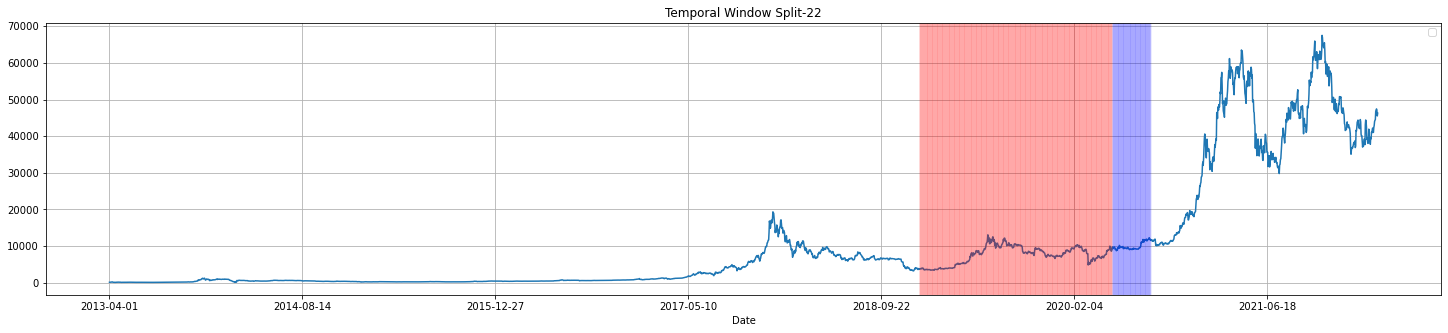

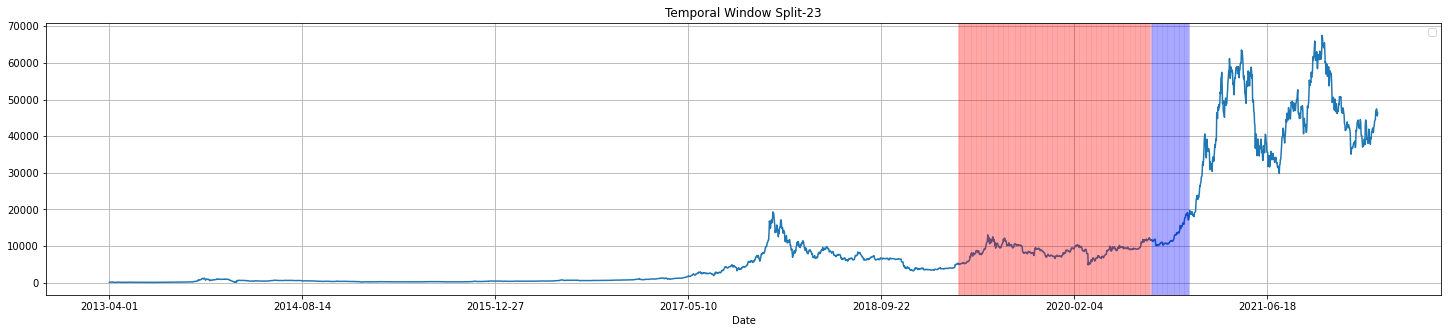

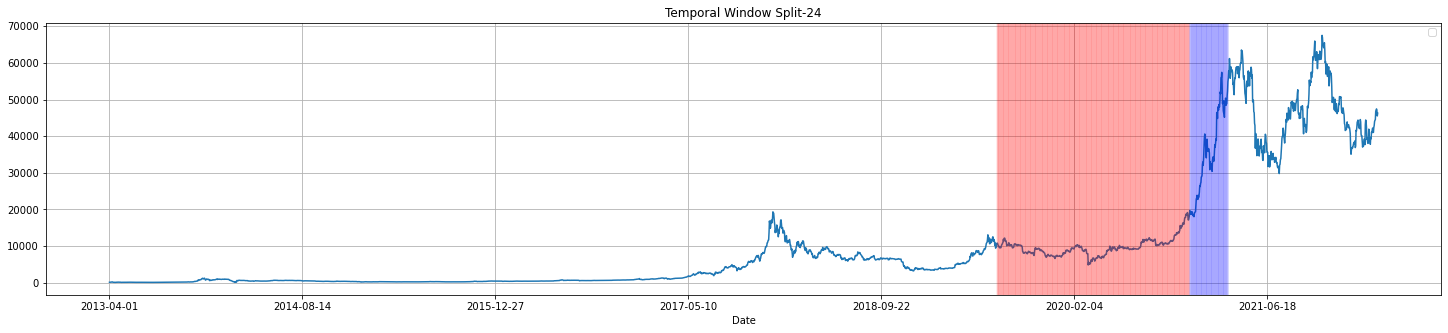

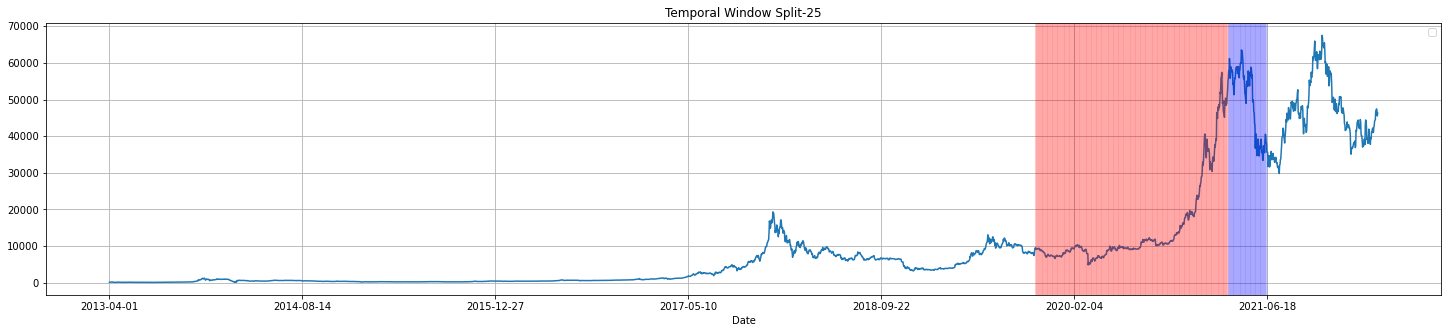

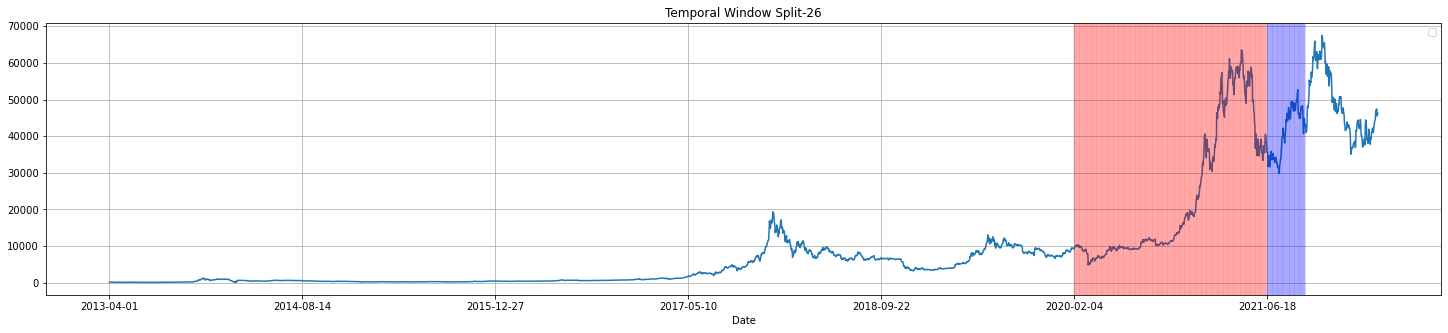

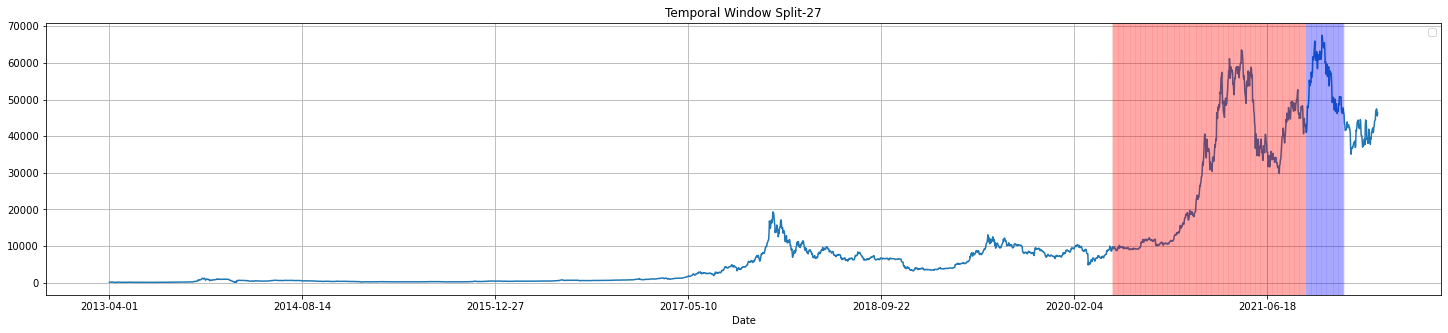

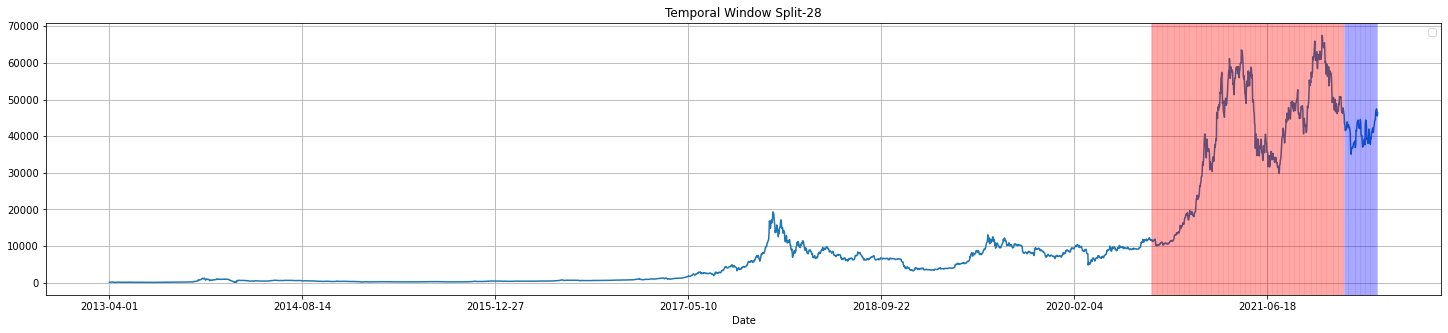

In [9]:
for i in range(len(train_splits)):
    visualize_split(i)

## SVR - Support Vector Regressor 

* SVR aims to fit the best line within a threshold value. 
* The threshold value is the distance between the hyperplane and boundary line. SVR performs well on small datasets.
* Here we have used SVR with Regularization parameter C =10000 with RBF Kernel with kernel coefficient gamma set to auto = 1 / n_features

In [10]:
svr_date_array = []

svr_y_test_array = []
svr_y_test_pred_array = []

svr_batch_id_array = []
svr_batch_id_array_result = []

svr_batch_mae_train_array = []
svr_batch_rmse_train_array = []

svr_batch_mae_test_array = []
svr_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1).values
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1).values

    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    svr = SVR(C=10000,gamma='auto',kernel='rbf')
    svr.fit(Xtrain_split, ytrain_split)

    ytrain_pred = svr.predict(Xtrain_split)
    ytest_pred = svr.predict(Xtest_split)

    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    svr_date_array.extend(test_splits[i]['Date'])
    svr_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    svr_y_test_pred_array.extend((ytest_pred.flatten()))
    svr_batch_id_array.extend([i]*len(test_splits[i]))

    svr_batch_id_array_result.append(i)
    svr_batch_mae_train_array.append(MAE_train)
    svr_batch_rmse_train_array.append(RMSE_train)
    svr_batch_mae_test_array.append(MAE_test)
    svr_batch_rmse_test_array.append(RMSE_test)

svr_result_test_df = pd.DataFrame()

svr_result_test_df['batch_id'] = svr_batch_id_array
svr_result_test_df['Date'] = svr_date_array
svr_result_test_df['y_test'] = svr_y_test_array
svr_result_test_df['y_test_pred'] = svr_y_test_pred_array

svr_y_test_array = svr_result_test_df['y_test']
svr_y_test_pred_array = svr_result_test_df['y_test_pred']

svr_result_metrics_df = pd.DataFrame()

svr_result_metrics_df['batch_id'] = svr_batch_id_array_result
svr_result_metrics_df['mae_train'] = svr_batch_mae_train_array
svr_result_metrics_df['rmse_train'] = svr_batch_rmse_train_array
svr_result_metrics_df['mae_test'] = svr_batch_mae_test_array
svr_result_metrics_df['rmse_test'] = svr_batch_rmse_test_array

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.32it/s]


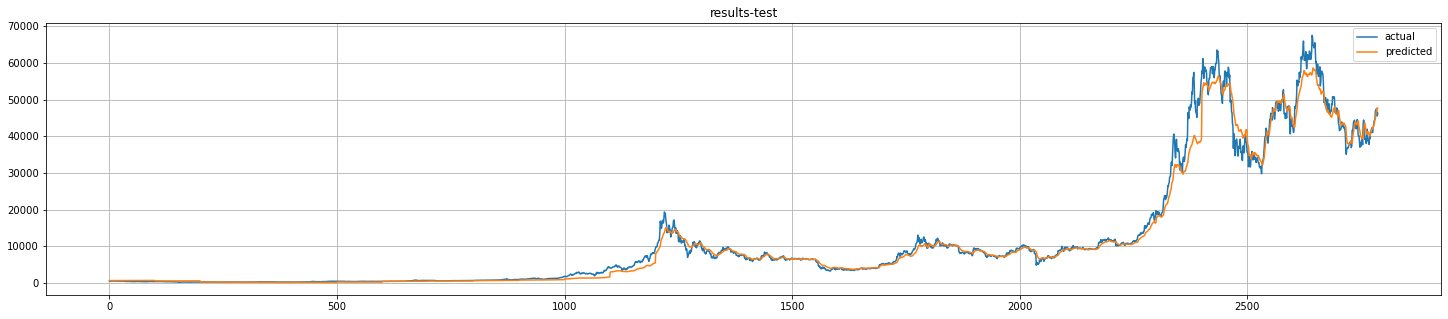

In [11]:
plot_results(svr_y_test_array,svr_y_test_pred_array,'results-test')

In [12]:
svr_result_metrics_df

,batch_id,mae_train,rmse_train,mae_test,rmse_test
0,0,111.340914,179.138356,231.676505,241.748531
1,1,127.835121,194.239163,260.644073,266.625799
2,2,102.839372,154.474913,36.586950,39.837368
3,3,62.468948,94.328378,93.160445,96.305382
4,4,52.212295,64.652588,186.787360,205.313372
5,5,49.547153,68.545890,179.364083,180.854552
6,6,39.434080,54.087404,98.676674,132.844687
7,7,39.894713,61.614064,91.377860,96.553606
8,8,39.942491,50.858817,156.030091,177.156501
9,9,53.224175,70.167554,357.874854,385.741804


In [13]:
pd.DataFrame(svr_result_metrics_df.mean()).drop(['batch_id'])

,0
mae_train,373.628313
rmse_train,587.368338
mae_test,1010.696067
rmse_test,1226.433289


In [14]:
svr_result_test_df.to_csv('svr_result_test.csv')
svr_result_metrics_df.to_csv('svr_result_metrics.csv')

#### Observations
1. The above plot shows the very less variations between the actual and predicted values.
2. SVR is able to predict good results and capture the trend, even when there is a sudden spike in prices.
3. The MAE and RMSE values for test data is higher than the training data. 

## XGBoost

It is a boosting ensemble model which is constructed from decision tree models. Trees are added sequentially to the ensemble and fit to correct the prediction errors made by prior models.
Here we have used 500 trees which tries to minimize squared errors.

In [15]:
xgb_date_array = []

xgb_y_test_array = []
xgb_y_test_pred_array = []

xgb_batch_id_array = []
xgb_batch_id_array_result = []
xgb_batch_mae_train_array = []
xgb_batch_rmse_train_array = []
xgb_batch_mape_train_array = []
xgb_batch_mae_test_array = []
xgb_batch_rmse_test_array = []
xgb_batch_mape_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    xgbm_reg = xgb.XGBRegressor(n_estimators=500,max_depth=3,objective='reg:squarederror',
                                learning_rate =0.01,n_jobs=-1)
    xgbm_reg.fit(Xtrain_split, ytrain_split)

    ytrain_pred = xgbm_reg.predict(Xtrain_split)
    ytest_pred = xgbm_reg.predict(Xtest_split)

    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    xgb_date_array.extend(test_splits[i]['Date'])
    xgb_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    xgb_y_test_pred_array.extend((ytest_pred.flatten()))
    xgb_batch_id_array.extend([i]*len(test_splits[i]))

    xgb_batch_id_array_result.append(i)
    xgb_batch_mae_train_array.append(MAE_train)
    xgb_batch_rmse_train_array.append(RMSE_train)
    xgb_batch_mae_test_array.append(MAE_test)
    xgb_batch_rmse_test_array.append(RMSE_test)

xgb_result_test_df = pd.DataFrame()

xgb_result_test_df['batch_id'] = xgb_batch_id_array
xgb_result_test_df['Date'] = xgb_date_array
xgb_result_test_df['y_test'] = xgb_y_test_array
xgb_result_test_df['y_test_pred'] = xgb_y_test_pred_array

xgb_y_test_array = xgb_result_test_df['y_test']
xgb_y_test_pred_array = xgb_result_test_df['y_test_pred']

xgb_result_metrics_df = pd.DataFrame()
xgb_result_metrics_df['batch_id'] = xgb_batch_id_array_result
xgb_result_metrics_df['mae_train'] = xgb_batch_mae_train_array
xgb_result_metrics_df['rmse_train'] = xgb_batch_rmse_train_array
xgb_result_metrics_df['mae_test'] = xgb_batch_mae_test_array
xgb_result_metrics_df['rmse_test'] = xgb_batch_rmse_test_array

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:16<00:00,  1.66it/s]


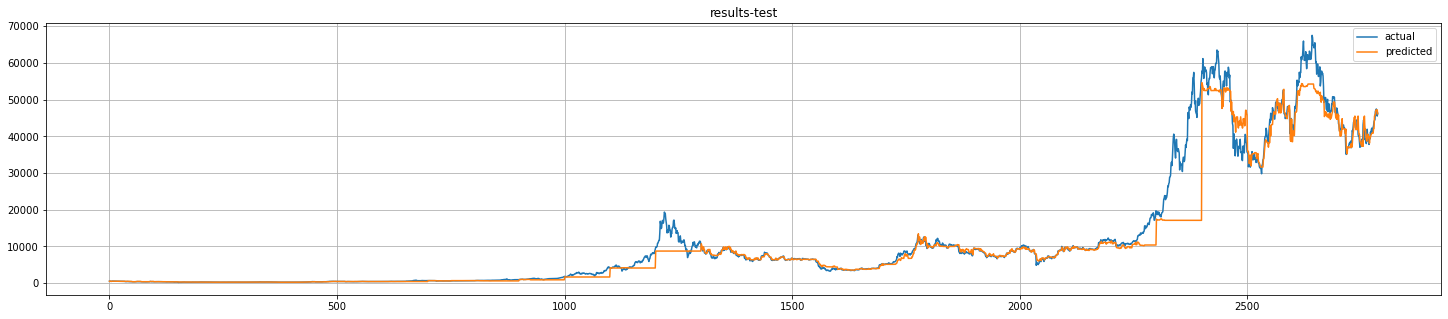

In [16]:
plot_results(xgb_y_test_array,xgb_y_test_pred_array,'results-test')

In [17]:
xgb_result_metrics_df

,batch_id,mae_train,rmse_train,mae_test,rmse_test
0,0,11.859019,20.403587,27.126389,34.521620
1,1,12.783799,20.873047,34.416564,40.473660
2,2,13.824655,21.542197,5.747914,7.597759
3,3,9.224104,13.420821,5.827518,8.399982
4,4,5.417919,7.554616,18.647140,26.722658
5,5,5.006124,6.998089,10.256142,13.269997
6,6,4.469115,6.190314,112.754032,158.040317
7,7,4.654941,6.721305,31.041989,38.275078
8,8,5.175397,7.447881,204.682678,237.544957
9,9,7.026946,10.936582,274.716454,331.039135


In [18]:
pd.DataFrame(xgb_result_metrics_df.mean()).drop(['batch_id'],axis=0)

,0
mae_train,145.573959
rmse_train,221.936961
mae_test,1600.207362
rmse_test,1947.327854


In [19]:
xgb_result_test_df.to_csv('xgb_result_test.csv')
xgb_result_metrics_df.to_csv('xgb_result_metrics.csv')

#### Observations 

1. XGBoost is highly overfitting. 
2. We can observe that when there is a sudden spike in prices. 
3. It predicts unsatisfactory results.

## Linear Regression

* Linear regression builds a linear relationship between the input variables and target variable by fitting a linear equation to observed data by minimizing the least squares.

* This technique requires regularization, as weights can grow exponentially to minimize errors.

* Gradient Descent is used to minimize the error. It is an iterative method which repeats the process until a minimum sum squared error is achieved.

* Here, we are using squared epsilon insensitive as loss function.

In [20]:
lr_date_array = []
lr_y_test_array = []
lr_y_test_pred_array = []
lr_batch_id_array = []
lr_batch_id_array_result = []
lr_batch_mae_train_array = []
lr_batch_rmse_train_array = []
lr_batch_mae_test_array = []
lr_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    sgd_reg = SGDRegressor(loss='squared_epsilon_insensitive',alpha=0.0001,penalty='elasticnet',shuffle=True,
                           tol=0.000001,l1_ratio=0.15,epsilon=0.01,learning_rate='adaptive',max_iter=1000,eta0 =0.01)
    sgd_reg.fit(Xtrain_split, ytrain_split)

    pickle.dump(sgd_reg, open(f'linear_reg_10.sav', 'wb'))

    ytrain_pred = sgd_reg.predict(Xtrain_split)
    ytest_pred = sgd_reg.predict(Xtest_split)

    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    lr_date_array.extend(test_splits[i]['Date'])
    lr_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    lr_y_test_pred_array.extend((ytest_pred.flatten()))
    lr_batch_id_array.extend([i]*len(test_splits[i]))

    lr_batch_id_array_result.append(i)
    lr_batch_mae_train_array.append(MAE_train)
    lr_batch_rmse_train_array.append(RMSE_train)
    lr_batch_mae_test_array.append(MAE_test)
    lr_batch_rmse_test_array.append(RMSE_test)

lr_result_test_df = pd.DataFrame()
lr_result_test_df['batch_id'] = lr_batch_id_array
lr_result_test_df['Date'] = lr_date_array
lr_result_test_df['y_test'] = lr_y_test_array
lr_result_test_df['y_test_pred'] = lr_y_test_pred_array
lr_y_test_array = lr_result_test_df['y_test']
lr_y_test_pred_array = lr_result_test_df['y_test_pred']

lr_result_metrics_df = pd.DataFrame()
lr_result_metrics_df['batch_id'] = lr_batch_id_array_result
lr_result_metrics_df['mae_train'] = lr_batch_mae_train_array
lr_result_metrics_df['rmse_train'] = lr_batch_rmse_train_array
lr_result_metrics_df['mae_test'] = lr_batch_mae_test_array
lr_result_metrics_df['rmse_test'] = lr_batch_rmse_test_array

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:04<00:00,  5.91it/s]


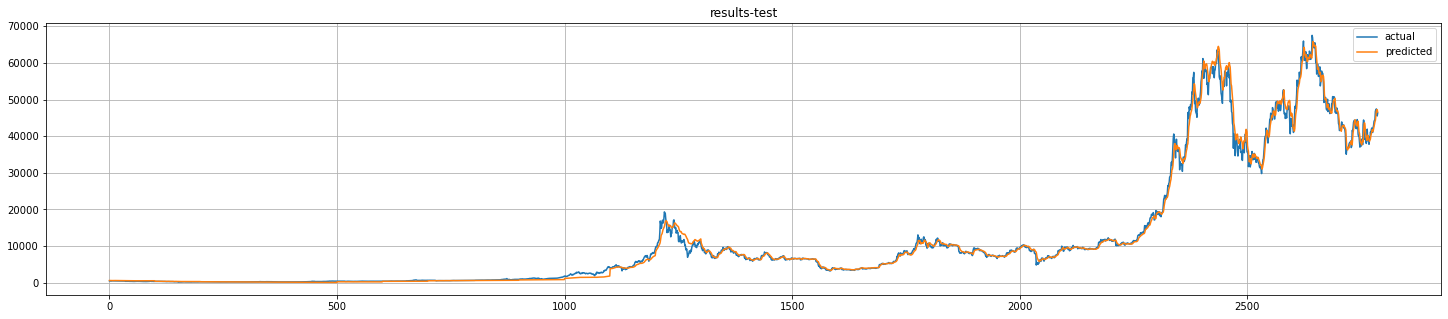

In [21]:
plot_results(lr_y_test_array,lr_y_test_pred_array,'results-test')

In [22]:
lr_result_metrics_df

,batch_id,mae_train,rmse_train,mae_test,rmse_test
0,0,72.130378,110.300145,151.142304,155.815837
1,1,70.938698,100.850524,77.790050,82.479763
2,2,88.259166,128.195225,11.903750,13.635795
3,3,65.265361,97.891369,96.357868,99.741265
4,4,57.980333,67.854986,208.424152,228.913422
5,5,58.441890,73.056730,162.935568,164.497569
6,6,48.296742,58.434861,134.236297,165.995863
7,7,46.033347,59.290264,45.965803,55.726057
8,8,43.098124,52.700607,153.525911,176.733757
9,9,56.952678,73.117815,363.073773,392.139906


In [23]:
pd.DataFrame(lr_result_metrics_df.mean()).drop(['batch_id'],axis=0)

,0
mae_train,299.948828
rmse_train,463.568705
mae_test,632.312717
rmse_test,796.517797


In [24]:
lr_result_test_df.to_csv('lr_result_test.csv')
lr_result_metrics_df.to_csv('lr_result_metrics.csv')

#### Observations 

1. The results of this following models are comparitively the best. 
2. We have obtained a good linear relationship between the features and target variables.
3. We prefer this model for prediction over others and it has best MAE and RMSE score, that is the least, stable score.
4. The Result plot is attesting the same. The trend for predicting value and actual value are very accurate. 

## LSTM - Long Short term Memory model

* LSTM are neural networks, sufficient in learning order dependence required in sequence prediction problems. 
* For our price prediction, We feed input to bidirectional layer of 400 cells, followed by a dropout of 25%.
* Output is fed to a bidirectional layer of 500 cells, which is followed by dropout of 30%. 
* RELU activation function is used to avoid vanishing or exploding gradient problem. 
* Adam optimizer is used for updating the weights.

### Callbacks

#### EarlyStopping

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop=EarlyStopping(monitor='root_mean_squared_error',min_delta=1e-3,patience=50,verbose=100,mode='min')

####  Learning Rate Scheduler

In [26]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
def changeLearningRate(epoch,lr):
    if (epoch+1) == 1:
        lr = 0.001
    if (epoch+1)%5==0:
        return lr*0.98
    else:
        return lr

lrschedule=LearningRateScheduler(changeLearningRate, verbose=1)

In [27]:
reduce_lr=ReduceLROnPlateau(monitor='root_mean_squared_error', factor=0.98,patience=3,verbose=1,mode='min')

In [28]:
callback_list=[reduce_lr,lrschedule,earlystop]

### Build Model

In [29]:
input_layer = Input(shape=(1, 55),name='input_layer')
lstm_1 = LSTM(400, return_sequences=True,activation='relu',name='lstm_1')(input_layer)
dropout_1 = Dropout(0.25,name='dropout_1')(lstm_1)
lstm_2 = LSTM(500, return_sequences=True,activation='relu',name='lstm_2')(dropout_1)
dropout_2 = Dropout(0.3,name='dropout_2')(lstm_2)
output_layer = Dense(1,name='output_layer')(dropout_2)

model=Model(inputs=input_layer,outputs=output_layer)
adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
model.compile(optimizer=adam, loss='log_cosh',metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1, 55)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 400)            729600    
                                                                 
 dropout_1 (Dropout)         (None, 1, 400)            0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 500)            1802000   
                                                                 
 dropout_2 (Dropout)         (None, 1, 500)            0         
                                                                 
 output_layer (Dense)        (None, 1, 1)              501       
                                                                 
Total params: 2,532,101
Trainable params: 2,532,101
Non-train

In [31]:
ytrain_split.shape

(500,)

In [32]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [33]:
Xtrain_split.shape

(500, 55)

In [34]:
lstm_date_array = []
lstm_y_test_array = []
lstm_y_test_pred_array = []
lstm_batch_id_array = []
lstm_batch_id_array_result = []
lstm_batch_mae_train_array = []
lstm_batch_rmse_train_array = []
lstm_batch_mae_test_array = []
lstm_batch_rmse_test_array = []

for i in range(len(train_splits)):
    print(f'Batch No. {i+1} of {len(train_splits)}')
    print('Train Data From',train_splits[i]['Date'].iloc[0],'-',train_splits[i]['next_day_closing_price'].min(),
          'to',train_splits[i]['Date'].iloc[-1],'-',train_splits[i]['next_day_closing_price'].max())
    
    print('Test Data From',test_splits[i]['Date'].iloc[0],'-',test_splits[i]['next_day_closing_price'].min(),
          'to',test_splits[i]['Date'].iloc[-1],'-',test_splits[i]['next_day_closing_price'].max())
    
    del model
    K.clear_session()
    tf.compat.v1.reset_default_graph()

    model=Model(inputs=input_layer,outputs=output_layer)
    model.compile(optimizer=adam, loss='Huber',metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1).values
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1).values

    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    Xtrain_split=np.reshape(Xtrain_split,(Xtrain_split.shape[0],1,Xtrain_split.shape[1]))
    Xtest_split=np.reshape(Xtest_split,(Xtest_split.shape[0],1,Xtest_split.shape[1]))

    model.fit(Xtrain_split,ytrain_split,epochs=500,batch_size=32,verbose=2,
              callbacks = [reduce_lr,lrschedule,earlystop])
    model.save(f'lstm_{i+1}')
    ytrain_pred = model.predict(Xtrain_split).reshape(-1,1)
    ytest_pred = model.predict(Xtest_split).reshape(-1,1)
    
    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    lstm_date_array.extend(test_splits[i]['Date'])
    lstm_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    lstm_y_test_pred_array.extend((ytest_pred.flatten()))
    lstm_batch_id_array.extend([i]*len(test_splits[i]))

    lstm_batch_id_array_result.append(i)
    lstm_batch_mae_train_array.append(MAE_train)
    lstm_batch_rmse_train_array.append(RMSE_train)
    lstm_batch_mae_test_array.append(MAE_test)
    lstm_batch_rmse_test_array.append(RMSE_test)
    print('*'*100)

lstm_result_test_df = pd.DataFrame()
lstm_result_test_df['batch_id'] = lstm_batch_id_array
lstm_result_test_df['Date'] = lstm_date_array
lstm_result_test_df['y_test'] = lstm_y_test_array
lstm_result_test_df['y_test_pred'] = lstm_y_test_pred_array
lstm_y_test_array = lstm_result_test_df['y_test']
lstm_y_test_pred_array = lstm_result_test_df['y_test_pred']
lstm_result_metrics_df = pd.DataFrame()
lstm_result_metrics_df['batch_id'] = lstm_batch_id_array_result
lstm_result_metrics_df['mae_train'] = lstm_batch_mae_train_array
lstm_result_metrics_df['rmse_train'] = lstm_batch_rmse_train_array
lstm_result_metrics_df['mae_test'] = lstm_batch_mae_test_array
lstm_result_metrics_df['rmse_test'] = lstm_batch_rmse_test_array

Batch No. 1 of 28
Train Data From 2013-04-01 - 68.4 to 2014-08-13 - 1237.6
Test Data From 2014-08-14 - 322.5 to 2014-11-21 - 522.0

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 411.5804 - root_mean_squared_error: 508.4794 - mae: 412.0804 - lr: 0.0010 - 2s/epoch - 151ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 411.1713 - root_mean_squared_error: 506.1364 - mae: 411.6713 - lr: 0.0010 - 230ms/epoch - 14ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 409.5135 - root_mean_squared_error: 505.7548 - mae: 410.0135 - lr: 0.0010 - 221ms/epoch - 14ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 403.0361 - root_mean_squared_error: 500.1414 - mae: 403.5361 - lr: 0.0010 - 219ms/epoch - 14ms/step

Epoch 5: LearningRateScheduler setting lea


Epoch 38: LearningRateScheduler setting learning rate to 0.000833747792057693.
Epoch 38/500
16/16 - 0s - loss: 261.7946 - root_mean_squared_error: 311.2944 - mae: 262.2945 - lr: 8.3375e-04 - 265ms/epoch - 17ms/step

Epoch 39: LearningRateScheduler setting learning rate to 0.000833747792057693.
Epoch 39/500
16/16 - 0s - loss: 261.1179 - root_mean_squared_error: 309.2808 - mae: 261.6176 - lr: 8.3375e-04 - 261ms/epoch - 16ms/step

Epoch 40: LearningRateScheduler setting learning rate to 0.0008170728362165391.
Epoch 40/500
16/16 - 0s - loss: 261.1749 - root_mean_squared_error: 306.0882 - mae: 261.6746 - lr: 8.1707e-04 - 264ms/epoch - 16ms/step

Epoch 41: LearningRateScheduler setting learning rate to 0.0008170728106051683.
Epoch 41/500
16/16 - 0s - loss: 262.0891 - root_mean_squared_error: 307.8877 - mae: 262.5889 - lr: 8.1707e-04 - 275ms/epoch - 17ms/step

Epoch 42: LearningRateScheduler setting learning rate to 0.0008170728106051683.
Epoch 42/500
16/16 - 0s - loss: 260.7742 - root_mean_


Epoch 74: LearningRateScheduler setting learning rate to 0.0006411707145161927.
Epoch 74/500
16/16 - 0s - loss: 260.2527 - root_mean_squared_error: 301.4242 - mae: 260.7524 - lr: 6.4117e-04 - 261ms/epoch - 16ms/step

Epoch 75: LearningRateScheduler setting learning rate to 0.0006283473002258688.
Epoch 75/500
16/16 - 0s - loss: 260.1709 - root_mean_squared_error: 301.1055 - mae: 260.6706 - lr: 6.2835e-04 - 265ms/epoch - 17ms/step

Epoch 76: LearningRateScheduler setting learning rate to 0.0006283472757786512.
Epoch 76/500
16/16 - 0s - loss: 260.9342 - root_mean_squared_error: 301.5281 - mae: 261.4339 - lr: 6.2835e-04 - 259ms/epoch - 16ms/step

Epoch 77: LearningRateScheduler setting learning rate to 0.0006283472757786512.
Epoch 77/500
16/16 - 0s - loss: 259.4161 - root_mean_squared_error: 300.7730 - mae: 259.9159 - lr: 6.2835e-04 - 262ms/epoch - 16ms/step

Epoch 78: LearningRateScheduler setting learning rate to 0.0006283472757786512.
Epoch 78/500
16/16 - 0s - loss: 260.1328 - root_mea

Epoch 109/500

Epoch 109: ReduceLROnPlateau reducing learning rate to 0.0004735488467849791.
16/16 - 0s - loss: 259.6380 - root_mean_squared_error: 297.5464 - mae: 260.1377 - lr: 4.7355e-04 - 273ms/epoch - 17ms/step

Epoch 110: LearningRateScheduler setting learning rate to 0.00046407785615883764.
Epoch 110/500
16/16 - 0s - loss: 258.7403 - root_mean_squared_error: 297.8575 - mae: 259.2401 - lr: 4.6408e-04 - 245ms/epoch - 15ms/step

Epoch 111: LearningRateScheduler setting learning rate to 0.0004640778643079102.
Epoch 111/500
16/16 - 0s - loss: 258.7590 - root_mean_squared_error: 296.5167 - mae: 259.2587 - lr: 4.6408e-04 - 259ms/epoch - 16ms/step

Epoch 112: LearningRateScheduler setting learning rate to 0.0004640778643079102.
Epoch 112/500
16/16 - 0s - loss: 259.9719 - root_mean_squared_error: 297.8844 - mae: 260.4717 - lr: 4.6408e-04 - 258ms/epoch - 16ms/step

Epoch 113: LearningRateScheduler setting learning rate to 0.0004640778643079102.
Epoch 113/500
16/16 - 0s - loss: 259.4039 - 

Epoch 143/500
16/16 - 0s - loss: 259.1855 - root_mean_squared_error: 295.5234 - mae: 259.6852 - lr: 3.4275e-04 - 251ms/epoch - 16ms/step

Epoch 144: LearningRateScheduler setting learning rate to 0.0003427535993978381.
Epoch 144/500
16/16 - 0s - loss: 257.9842 - root_mean_squared_error: 295.9876 - mae: 258.4839 - lr: 3.4275e-04 - 259ms/epoch - 16ms/step

Epoch 145: LearningRateScheduler setting learning rate to 0.00033589852740988134.
Epoch 145/500
16/16 - 0s - loss: 259.1313 - root_mean_squared_error: 295.8203 - mae: 259.6311 - lr: 3.3590e-04 - 247ms/epoch - 15ms/step

Epoch 146: LearningRateScheduler setting learning rate to 0.00033589854137971997.
Epoch 146/500
16/16 - 0s - loss: 258.4063 - root_mean_squared_error: 294.3429 - mae: 258.9059 - lr: 3.3590e-04 - 261ms/epoch - 16ms/step

Epoch 147: LearningRateScheduler setting learning rate to 0.00033589854137971997.
Epoch 147/500
16/16 - 0s - loss: 258.1393 - root_mean_squared_error: 296.4926 - mae: 258.6390 - lr: 3.3590e-04 - 248ms/ep

Epoch 177/500
16/16 - 0s - loss: 258.0655 - root_mean_squared_error: 295.3947 - mae: 258.5651 - lr: 2.4312e-04 - 258ms/epoch - 16ms/step

Epoch 178: LearningRateScheduler setting learning rate to 0.00024312263121828437.
Epoch 178/500
16/16 - 0s - loss: 258.7339 - root_mean_squared_error: 296.6732 - mae: 259.2338 - lr: 2.4312e-04 - 248ms/epoch - 16ms/step

Epoch 179: LearningRateScheduler setting learning rate to 0.00024312263121828437.
Epoch 179/500

Epoch 179: ReduceLROnPlateau reducing learning rate to 0.00023826017859391866.
16/16 - 0s - loss: 258.9269 - root_mean_squared_error: 296.5784 - mae: 259.4266 - lr: 2.3826e-04 - 270ms/epoch - 17ms/step

Epoch 180: LearningRateScheduler setting learning rate to 0.00023349497787421568.
Epoch 180/500
16/16 - 0s - loss: 258.0623 - root_mean_squared_error: 296.0064 - mae: 258.5620 - lr: 2.3349e-04 - 247ms/epoch - 15ms/step

Epoch 181: LearningRateScheduler setting learning rate to 0.00023349498223979026.
Epoch 181/500
16/16 - 0s - loss: 258.530


Epoch 211: LearningRateScheduler setting learning rate to 0.00016900313494261354.
Epoch 211/500
16/16 - 0s - loss: 258.0638 - root_mean_squared_error: 295.9879 - mae: 258.5634 - lr: 1.6900e-04 - 251ms/epoch - 16ms/step

Epoch 212: LearningRateScheduler setting learning rate to 0.00016900313494261354.
Epoch 212/500
16/16 - 0s - loss: 257.9215 - root_mean_squared_error: 294.2996 - mae: 258.4213 - lr: 1.6900e-04 - 256ms/epoch - 16ms/step

Epoch 213: LearningRateScheduler setting learning rate to 0.00016900313494261354.
Epoch 213/500

Epoch 213: ReduceLROnPlateau reducing learning rate to 0.00016562307224376126.
16/16 - 0s - loss: 258.6130 - root_mean_squared_error: 296.6657 - mae: 259.1128 - lr: 1.6562e-04 - 249ms/epoch - 16ms/step

Epoch 214: LearningRateScheduler setting learning rate to 0.0001656230742810294.
Epoch 214/500
16/16 - 0s - loss: 258.5193 - root_mean_squared_error: 295.4276 - mae: 259.0191 - lr: 1.6562e-04 - 257ms/epoch - 16ms/step

Epoch 215: LearningRateScheduler setting

****************************************************************************************************
Batch No. 2 of 28
Train Data From 2013-07-10 - 89.0 to 2014-11-21 - 1237.6
Test Data From 2014-11-22 - 164.9 to 2015-03-01 - 380.6

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 206.7338 - root_mean_squared_error: 259.7368 - mae: 207.2334 - lr: 0.0010 - 2s/epoch - 129ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 205.8876 - root_mean_squared_error: 259.6332 - mae: 206.3868 - lr: 0.0010 - 227ms/epoch - 14ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 205.1707 - root_mean_squared_error: 258.4599 - mae: 205.6700 - lr: 0.0010 - 217ms/epoch - 14ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 205.3323 - root_mean_squared_error: 259.06


Epoch 36: LearningRateScheduler setting learning rate to 0.0007536419434472919.
Epoch 36/500

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.000738569104578346.
16/16 - 0s - loss: 204.5390 - root_mean_squared_error: 258.1294 - mae: 205.0384 - lr: 7.3857e-04 - 278ms/epoch - 17ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.0007385691278614104.
Epoch 37/500
16/16 - 0s - loss: 205.0760 - root_mean_squared_error: 258.6881 - mae: 205.5753 - lr: 7.3857e-04 - 275ms/epoch - 17ms/step

Epoch 38: LearningRateScheduler setting learning rate to 0.0007385691278614104.
Epoch 38/500
16/16 - 0s - loss: 205.3784 - root_mean_squared_error: 258.5265 - mae: 205.8778 - lr: 7.3857e-04 - 274ms/epoch - 17ms/step

Epoch 39: LearningRateScheduler setting learning rate to 0.0007385691278614104.
Epoch 39/500

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0007237977453041822.
16/16 - 0s - loss: 204.7963 - root_mean_squared_error: 257.8181 - mae: 205.2955 - lr: 7.2380e-04 - 2

Epoch 70/500

Epoch 70: ReduceLROnPlateau reducing learning rate to 0.0005238831252790988.
16/16 - 0s - loss: 205.3478 - root_mean_squared_error: 258.8801 - mae: 205.8470 - lr: 5.2388e-04 - 270ms/epoch - 17ms/step

Epoch 71: LearningRateScheduler setting learning rate to 0.0005238831508904696.
Epoch 71/500
16/16 - 0s - loss: 205.1132 - root_mean_squared_error: 257.9694 - mae: 205.6125 - lr: 5.2388e-04 - 264ms/epoch - 16ms/step

Epoch 72: LearningRateScheduler setting learning rate to 0.0005238831508904696.
Epoch 72/500
16/16 - 0s - loss: 204.9074 - root_mean_squared_error: 258.4336 - mae: 205.4067 - lr: 5.2388e-04 - 259ms/epoch - 16ms/step

Epoch 73: LearningRateScheduler setting learning rate to 0.0005238831508904696.
Epoch 73/500

Epoch 73: ReduceLROnPlateau reducing learning rate to 0.0005134054878726601.
16/16 - 0s - loss: 204.7094 - root_mean_squared_error: 258.2200 - mae: 205.2089 - lr: 5.1341e-04 - 270ms/epoch - 17ms/step

Epoch 74: LearningRateScheduler setting learning rate to


Epoch 104: LearningRateScheduler setting learning rate to 0.0003716016944963485.
Epoch 104/500
16/16 - 0s - loss: 204.8383 - root_mean_squared_error: 257.9277 - mae: 205.3377 - lr: 3.7160e-04 - 258ms/epoch - 16ms/step

Epoch 105: LearningRateScheduler setting learning rate to 0.0003641696606064215.
Epoch 105/500
16/16 - 0s - loss: 205.3984 - root_mean_squared_error: 258.5349 - mae: 205.8977 - lr: 3.6417e-04 - 260ms/epoch - 16ms/step

Epoch 106: LearningRateScheduler setting learning rate to 0.0003641696530394256.
Epoch 106/500

Epoch 106: ReduceLROnPlateau reducing learning rate to 0.0003568862599786371.
16/16 - 0s - loss: 204.9211 - root_mean_squared_error: 257.4551 - mae: 205.4202 - lr: 3.5689e-04 - 262ms/epoch - 16ms/step

Epoch 107: LearningRateScheduler setting learning rate to 0.0003568862739484757.
Epoch 107/500
16/16 - 0s - loss: 204.8783 - root_mean_squared_error: 258.9655 - mae: 205.3776 - lr: 3.5689e-04 - 257ms/epoch - 16ms/step

Epoch 108: LearningRateScheduler setting lea

INFO:tensorflow:Assets written to: lstm_2\assets


****************************************************************************************************
Batch No. 3 of 28
Train Data From 2013-10-18 - 111.6 to 2015-03-01 - 1237.6
Test Data From 2015-03-02 - 218.0 to 2015-06-09 - 295.6

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 172.8457 - root_mean_squared_error: 224.3306 - mae: 173.3450 - lr: 0.0010 - 2s/epoch - 130ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 173.0291 - root_mean_squared_error: 224.6968 - mae: 173.5284 - lr: 0.0010 - 232ms/epoch - 14ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 173.2374 - root_mean_squared_error: 226.0366 - mae: 173.7370 - lr: 0.0010 - 227ms/epoch - 14ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009

Epoch 34/500
16/16 - 0s - loss: 172.6951 - root_mean_squared_error: 224.5596 - mae: 173.1946 - lr: 7.2380e-04 - 275ms/epoch - 17ms/step

Epoch 35: LearningRateScheduler setting learning rate to 0.0007093218143563718.
Epoch 35/500
16/16 - 0s - loss: 172.9821 - root_mean_squared_error: 225.1450 - mae: 173.4813 - lr: 7.0932e-04 - 275ms/epoch - 17ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.000709321815520525.
Epoch 36/500

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0006951353792101144.
16/16 - 0s - loss: 173.0141 - root_mean_squared_error: 224.9634 - mae: 173.5134 - lr: 6.9514e-04 - 288ms/epoch - 18ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.0006951353861950338.
Epoch 37/500
16/16 - 0s - loss: 172.8261 - root_mean_squared_error: 224.3853 - mae: 173.3254 - lr: 6.9514e-04 - 275ms/epoch - 17ms/step

Epoch 38: LearningRateScheduler setting learning rate to 0.0006951353861950338.
Epoch 38/500
16/16 - 0s - loss: 173.1488 - root_mean_sq

16/16 - 0s - loss: 172.9311 - root_mean_squared_error: 224.1919 - mae: 173.4306 - lr: 5.0314e-04 - 278ms/epoch - 17ms/step

Epoch 69: LearningRateScheduler setting learning rate to 0.0005031373584643006.
Epoch 69/500
16/16 - 0s - loss: 172.8842 - root_mean_squared_error: 223.8076 - mae: 173.3837 - lr: 5.0314e-04 - 269ms/epoch - 17ms/step

Epoch 70: LearningRateScheduler setting learning rate to 0.0004930746112950146.
Epoch 70/500
16/16 - 0s - loss: 172.7356 - root_mean_squared_error: 225.0015 - mae: 173.2348 - lr: 4.9307e-04 - 268ms/epoch - 17ms/step

Epoch 71: LearningRateScheduler setting learning rate to 0.0004930745926685631.
Epoch 71/500

Epoch 71: ReduceLROnPlateau reducing learning rate to 0.00048321310081519183.
16/16 - 0s - loss: 172.6276 - root_mean_squared_error: 224.4033 - mae: 173.1268 - lr: 4.8321e-04 - 268ms/epoch - 17ms/step

Epoch 72: LearningRateScheduler setting learning rate to 0.0004832131089642644.
Epoch 72/500
16/16 - 0s - loss: 172.8920 - root_mean_squared_error

INFO:tensorflow:Assets written to: lstm_3\assets


****************************************************************************************************
Batch No. 4 of 28
Train Data From 2014-01-26 - 111.6 to 2015-06-09 - 953.3
Test Data From 2015-06-10 - 211.4 to 2015-09-17 - 310.4

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 142.1079 - root_mean_squared_error: 169.0835 - mae: 142.6074 - lr: 0.0010 - 2s/epoch - 128ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 136.1862 - root_mean_squared_error: 168.2742 - mae: 136.6855 - lr: 0.0010 - 231ms/epoch - 14ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 135.9853 - root_mean_squared_error: 167.1382 - mae: 136.4846 - lr: 0.0010 - 232ms/epoch - 14ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 135.5547 - root_mean_squared_error: 164.97


Epoch 35: LearningRateScheduler setting learning rate to 0.0007237977453041822.
Epoch 35/500
16/16 - 0s - loss: 136.0038 - root_mean_squared_error: 167.2586 - mae: 136.5031 - lr: 7.2380e-04 - 284ms/epoch - 18ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.0007237977697513998.
Epoch 36/500
16/16 - 0s - loss: 135.8944 - root_mean_squared_error: 166.5073 - mae: 136.3939 - lr: 7.2380e-04 - 288ms/epoch - 18ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.0007237977697513998.
Epoch 37/500

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0007093218143563718.
16/16 - 0s - loss: 135.6114 - root_mean_squared_error: 166.5385 - mae: 136.1108 - lr: 7.0932e-04 - 284ms/epoch - 18ms/step

Epoch 38: LearningRateScheduler setting learning rate to 0.000709321815520525.
Epoch 38/500
16/16 - 0s - loss: 135.7387 - root_mean_squared_error: 166.6222 - mae: 136.2378 - lr: 7.0932e-04 - 279ms/epoch - 17ms/step

Epoch 39: LearningRateScheduler setting learning rate 

INFO:tensorflow:Assets written to: lstm_4\assets


****************************************************************************************************
Batch No. 5 of 28
Train Data From 2014-05-06 - 164.9 to 2015-09-17 - 669.4
Test Data From 2015-09-18 - 226.3 to 2015-12-26 - 463.2

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 114.8951 - root_mean_squared_error: 141.0334 - mae: 115.3945 - lr: 0.0010 - 2s/epoch - 112ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 110.3938 - root_mean_squared_error: 154.3104 - mae: 110.8929 - lr: 0.0010 - 219ms/epoch - 14ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 109.6054 - root_mean_squared_error: 151.4120 - mae: 110.1043 - lr: 0.0010 - 219ms/epoch - 14ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00098

Epoch 34/500

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0007093218143563718.
16/16 - 0s - loss: 109.4143 - root_mean_squared_error: 148.3872 - mae: 109.9135 - lr: 7.0932e-04 - 267ms/epoch - 17ms/step

Epoch 35: LearningRateScheduler setting learning rate to 0.0006951353792101144.
Epoch 35/500
16/16 - 0s - loss: 109.1817 - root_mean_squared_error: 148.1878 - mae: 109.6807 - lr: 6.9514e-04 - 265ms/epoch - 17ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.0006951353861950338.
Epoch 36/500
16/16 - 0s - loss: 109.7654 - root_mean_squared_error: 148.2514 - mae: 110.2648 - lr: 6.9514e-04 - 274ms/epoch - 17ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.0006951353861950338.
Epoch 37/500

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.000681232678471133.
16/16 - 0s - loss: 109.6673 - root_mean_squared_error: 148.8688 - mae: 110.1663 - lr: 6.8123e-04 - 267ms/epoch - 17ms/step

Epoch 38: LearningRateScheduler setting learning rate to 

INFO:tensorflow:Assets written to: lstm_5\assets


****************************************************************************************************
Batch No. 6 of 28
Train Data From 2014-08-14 - 164.9 to 2015-12-26 - 522.0
Test Data From 2015-12-27 - 368.0 to 2016-04-04 - 457.0

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 65.1090 - root_mean_squared_error: 86.0352 - mae: 65.6075 - lr: 0.0010 - 2s/epoch - 107ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 65.1663 - root_mean_squared_error: 87.5212 - mae: 65.6646 - lr: 0.0010 - 217ms/epoch - 14ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 65.3375 - root_mean_squared_error: 86.7346 - mae: 65.8363 - lr: 0.0010 - 226ms/epoch - 14ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00098000004654


Epoch 36: LearningRateScheduler setting learning rate to 0.0007385691278614104.
Epoch 36/500

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0007237977453041822.
16/16 - 0s - loss: 64.6355 - root_mean_squared_error: 86.7685 - mae: 65.1336 - lr: 7.2380e-04 - 278ms/epoch - 17ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.0007237977697513998.
Epoch 37/500
16/16 - 0s - loss: 64.9025 - root_mean_squared_error: 87.5942 - mae: 65.4010 - lr: 7.2380e-04 - 264ms/epoch - 17ms/step

Epoch 38: LearningRateScheduler setting learning rate to 0.0007237977697513998.
Epoch 38/500
16/16 - 0s - loss: 64.7536 - root_mean_squared_error: 86.0684 - mae: 65.2519 - lr: 7.2380e-04 - 274ms/epoch - 17ms/step

Epoch 39: LearningRateScheduler setting learning rate to 0.0007237977697513998.
Epoch 39/500

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0007093218143563718.
16/16 - 0s - loss: 64.7293 - root_mean_squared_error: 87.6937 - mae: 65.2279 - lr: 7.0932e-04 - 268ms/epoch 

INFO:tensorflow:Assets written to: lstm_6\assets


****************************************************************************************************
Batch No. 7 of 28
Train Data From 2014-11-22 - 164.9 to 2016-04-04 - 463.2
Test Data From 2016-04-05 - 417.7 to 2016-07-13 - 761.2

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 64.7961 - root_mean_squared_error: 82.4362 - mae: 65.2944 - lr: 0.0010 - 2s/epoch - 107ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 64.5679 - root_mean_squared_error: 82.3451 - mae: 65.0663 - lr: 0.0010 - 225ms/epoch - 14ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 64.7548 - root_mean_squared_error: 83.1234 - mae: 65.2531 - lr: 0.0010 - 218ms/epoch - 14ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 64.7997 - root_mean_squared_error: 82.6624 - mae: 6


Epoch 36: LearningRateScheduler setting learning rate to 0.0007536419434472919.
Epoch 36/500

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.000738569104578346.
16/16 - 0s - loss: 64.4893 - root_mean_squared_error: 82.8165 - mae: 64.9877 - lr: 7.3857e-04 - 269ms/epoch - 17ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.0007385691278614104.
Epoch 37/500
16/16 - 0s - loss: 64.4125 - root_mean_squared_error: 82.1131 - mae: 64.9110 - lr: 7.3857e-04 - 267ms/epoch - 17ms/step

Epoch 38: LearningRateScheduler setting learning rate to 0.0007385691278614104.
Epoch 38/500
16/16 - 0s - loss: 64.5467 - root_mean_squared_error: 82.1558 - mae: 65.0453 - lr: 7.3857e-04 - 268ms/epoch - 17ms/step

Epoch 39: LearningRateScheduler setting learning rate to 0.0007385691278614104.
Epoch 39/500

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0007237977453041822.
16/16 - 0s - loss: 64.6536 - root_mean_squared_error: 81.6130 - mae: 65.1522 - lr: 7.2380e-04 - 267ms/epoch -

INFO:tensorflow:Assets written to: lstm_7\assets


****************************************************************************************************
Batch No. 8 of 28
Train Data From 2015-03-02 - 211.4 to 2016-07-13 - 761.2
Test Data From 2016-07-14 - 513.4 to 2016-10-21 - 676.3

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 104.0618 - root_mean_squared_error: 139.0707 - mae: 104.5608 - lr: 0.0010 - 2s/epoch - 116ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 102.2171 - root_mean_squared_error: 127.1797 - mae: 102.7167 - lr: 0.0010 - 225ms/epoch - 14ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 102.6497 - root_mean_squared_error: 126.9998 - mae: 103.1495 - lr: 0.0010 - 217ms/epoch - 14ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 102.0172 - root_mean_squared_error: 129.41

Epoch 34/500
16/16 - 0s - loss: 102.7953 - root_mean_squared_error: 129.1250 - mae: 103.2951 - lr: 7.2380e-04 - 272ms/epoch - 17ms/step

Epoch 35: LearningRateScheduler setting learning rate to 0.0007093218143563718.
Epoch 35/500
16/16 - 0s - loss: 102.4569 - root_mean_squared_error: 129.0450 - mae: 102.9565 - lr: 7.0932e-04 - 267ms/epoch - 17ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.000709321815520525.
Epoch 36/500

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0006951353792101144.
16/16 - 0s - loss: 102.3176 - root_mean_squared_error: 130.5039 - mae: 102.8171 - lr: 6.9514e-04 - 287ms/epoch - 18ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.0006951353861950338.
Epoch 37/500
16/16 - 0s - loss: 102.1348 - root_mean_squared_error: 129.9732 - mae: 102.6344 - lr: 6.9514e-04 - 270ms/epoch - 17ms/step

Epoch 38: LearningRateScheduler setting learning rate to 0.0006951353861950338.
Epoch 38/500
16/16 - 0s - loss: 102.4644 - root_mean_sq

INFO:tensorflow:Assets written to: lstm_8\assets


****************************************************************************************************
Batch No. 9 of 28
Train Data From 2015-06-10 - 211.4 to 2016-10-21 - 761.2
Test Data From 2016-10-22 - 650.5 to 2017-01-29 - 1135.4

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 129.4117 - root_mean_squared_error: 159.2003 - mae: 129.9112 - lr: 0.0010 - 2s/epoch - 109ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 122.3678 - root_mean_squared_error: 146.9127 - mae: 122.8667 - lr: 0.0010 - 226ms/epoch - 14ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 121.3182 - root_mean_squared_error: 148.2445 - mae: 121.8170 - lr: 0.0010 - 233ms/epoch - 15ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 120.6381 - root_mean_squared_error: 146.7

Epoch 35/500
16/16 - 0s - loss: 121.0172 - root_mean_squared_error: 146.8409 - mae: 121.5159 - lr: 7.3857e-04 - 272ms/epoch - 17ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.0007385691278614104.
Epoch 36/500
16/16 - 0s - loss: 120.1030 - root_mean_squared_error: 146.3745 - mae: 120.6018 - lr: 7.3857e-04 - 277ms/epoch - 17ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.0007385691278614104.
Epoch 37/500

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0007237977453041822.
16/16 - 0s - loss: 121.1688 - root_mean_squared_error: 146.9017 - mae: 121.6676 - lr: 7.2380e-04 - 276ms/epoch - 17ms/step

Epoch 38: LearningRateScheduler setting learning rate to 0.0007237977697513998.
Epoch 38/500
16/16 - 0s - loss: 120.1326 - root_mean_squared_error: 146.5051 - mae: 120.6314 - lr: 7.2380e-04 - 275ms/epoch - 17ms/step

Epoch 39: LearningRateScheduler setting learning rate to 0.0007237977697513998.
Epoch 39/500
16/16 - 0s - loss: 120.2764 - root_mean_s

Epoch 69/500
16/16 - 0s - loss: 119.8704 - root_mean_squared_error: 146.6656 - mae: 120.3689 - lr: 5.2388e-04 - 266ms/epoch - 17ms/step

Epoch 70: LearningRateScheduler setting learning rate to 0.0005134054878726601.
Epoch 70/500

Epoch 70: ReduceLROnPlateau reducing learning rate to 0.0005031373712699861.
16/16 - 0s - loss: 120.8668 - root_mean_squared_error: 147.1788 - mae: 121.3657 - lr: 5.0314e-04 - 270ms/epoch - 17ms/step

Epoch 71: LearningRateScheduler setting learning rate to 0.0005031373584643006.
Epoch 71/500
16/16 - 0s - loss: 120.2531 - root_mean_squared_error: 147.0966 - mae: 120.7517 - lr: 5.0314e-04 - 260ms/epoch - 16ms/step

Epoch 72: LearningRateScheduler setting learning rate to 0.0005031373584643006.
Epoch 72/500
16/16 - 0s - loss: 120.0819 - root_mean_squared_error: 146.8098 - mae: 120.5807 - lr: 5.0314e-04 - 275ms/epoch - 17ms/step

Epoch 73: LearningRateScheduler setting learning rate to 0.0005031373584643006.
Epoch 73/500

Epoch 73: ReduceLROnPlateau reducing lea

Epoch 103/500
16/16 - 0s - loss: 120.2823 - root_mean_squared_error: 146.8329 - mae: 120.7812 - lr: 3.6417e-04 - 259ms/epoch - 16ms/step

Epoch 104: LearningRateScheduler setting learning rate to 0.0003641696530394256.
Epoch 104/500
16/16 - 0s - loss: 119.7328 - root_mean_squared_error: 146.0875 - mae: 120.2313 - lr: 3.6417e-04 - 271ms/epoch - 17ms/step

Epoch 105: LearningRateScheduler setting learning rate to 0.0003568862599786371.
Epoch 105/500

Epoch 105: ReduceLROnPlateau reducing learning rate to 0.0003497485484695062.
16/16 - 0s - loss: 120.1095 - root_mean_squared_error: 146.1613 - mae: 120.6082 - lr: 3.4975e-04 - 271ms/epoch - 17ms/step

Epoch 106: LearningRateScheduler setting learning rate to 0.0003497485595289618.
Epoch 106/500
16/16 - 0s - loss: 120.2754 - root_mean_squared_error: 147.1819 - mae: 120.7741 - lr: 3.4975e-04 - 264ms/epoch - 16ms/step

Epoch 107: LearningRateScheduler setting learning rate to 0.0003497485595289618.
Epoch 107/500
16/16 - 0s - loss: 119.6328 - r

INFO:tensorflow:Assets written to: lstm_9\assets


****************************************************************************************************
Batch No. 10 of 28
Train Data From 2015-09-18 - 226.3 to 2017-01-29 - 1135.4
Test Data From 2017-01-30 - 939.7 to 2017-05-09 - 1752.3

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 157.4057 - root_mean_squared_error: 198.4770 - mae: 157.9050 - lr: 0.0010 - 2s/epoch - 113ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 154.5906 - root_mean_squared_error: 185.0999 - mae: 155.0905 - lr: 0.0010 - 241ms/epoch - 15ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 154.7088 - root_mean_squared_error: 184.6628 - mae: 155.2086 - lr: 0.0010 - 230ms/epoch - 14ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 153.8924 - root_mean_squared_error: 187

Epoch 34/500
16/16 - 0s - loss: 154.2026 - root_mean_squared_error: 188.1127 - mae: 154.7025 - lr: 7.2380e-04 - 283ms/epoch - 18ms/step

Epoch 35: LearningRateScheduler setting learning rate to 0.0007093218143563718.
Epoch 35/500
16/16 - 0s - loss: 153.6993 - root_mean_squared_error: 188.9126 - mae: 154.1992 - lr: 7.0932e-04 - 280ms/epoch - 17ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.000709321815520525.
Epoch 36/500

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0006951353792101144.
16/16 - 0s - loss: 154.1288 - root_mean_squared_error: 190.9868 - mae: 154.6285 - lr: 6.9514e-04 - 278ms/epoch - 17ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.0006951353861950338.
Epoch 37/500
16/16 - 0s - loss: 154.2252 - root_mean_squared_error: 188.6413 - mae: 154.7249 - lr: 6.9514e-04 - 274ms/epoch - 17ms/step

Epoch 38: LearningRateScheduler setting learning rate to 0.0006951353861950338.
Epoch 38/500
16/16 - 0s - loss: 154.0191 - root_mean_sq

INFO:tensorflow:Assets written to: lstm_10\assets


****************************************************************************************************
Batch No. 11 of 28
Train Data From 2015-12-27 - 368.0 to 2017-05-09 - 1752.3
Test Data From 2017-05-10 - 1686.4 to 2017-08-17 - 4387.4

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 234.4796 - root_mean_squared_error: 318.1418 - mae: 234.9793 - lr: 0.0010 - 2s/epoch - 115ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 223.8434 - root_mean_squared_error: 291.8282 - mae: 224.3428 - lr: 0.0010 - 223ms/epoch - 14ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 221.7244 - root_mean_squared_error: 298.8738 - mae: 222.2238 - lr: 0.0010 - 225ms/epoch - 14ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 221.7787 - root_mean_squared_error: 29


Epoch 35: LearningRateScheduler setting learning rate to 0.0007237977453041822.
Epoch 35/500

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0007093218143563718.
16/16 - 0s - loss: 221.1576 - root_mean_squared_error: 299.4912 - mae: 221.6569 - lr: 7.0932e-04 - 279ms/epoch - 17ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.000709321815520525.
Epoch 36/500
16/16 - 0s - loss: 221.0675 - root_mean_squared_error: 294.0071 - mae: 221.5669 - lr: 7.0932e-04 - 269ms/epoch - 17ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.000709321815520525.
Epoch 37/500
16/16 - 0s - loss: 220.6747 - root_mean_squared_error: 297.4998 - mae: 221.1740 - lr: 7.0932e-04 - 281ms/epoch - 18ms/step

Epoch 38: LearningRateScheduler setting learning rate to 0.000709321815520525.
Epoch 38/500

Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0006951353792101144.
16/16 - 0s - loss: 221.2677 - root_mean_squared_error: 298.0092 - mae: 221.7671 - lr: 6.9514e-04 - 277


Epoch 69: LearningRateScheduler setting learning rate to 0.0005134054808877409.
Epoch 69/500
16/16 - 0s - loss: 222.2543 - root_mean_squared_error: 295.5485 - mae: 222.7537 - lr: 5.1341e-04 - 262ms/epoch - 16ms/step

Epoch 70: LearningRateScheduler setting learning rate to 0.0005031373712699861.
Epoch 70/500
16/16 - 0s - loss: 222.0172 - root_mean_squared_error: 300.9096 - mae: 222.5165 - lr: 5.0314e-04 - 257ms/epoch - 16ms/step

Epoch 71: LearningRateScheduler setting learning rate to 0.0005031373584643006.
Epoch 71/500

Epoch 71: ReduceLROnPlateau reducing learning rate to 0.0004930746112950146.
16/16 - 0s - loss: 220.9278 - root_mean_squared_error: 295.5235 - mae: 221.4274 - lr: 4.9307e-04 - 258ms/epoch - 16ms/step

Epoch 72: LearningRateScheduler setting learning rate to 0.0004930745926685631.
Epoch 72/500
16/16 - 0s - loss: 220.9059 - root_mean_squared_error: 295.3988 - mae: 221.4052 - lr: 4.9307e-04 - 288ms/epoch - 18ms/step

Epoch 73: LearningRateScheduler setting learning rate


Epoch 103: LearningRateScheduler setting learning rate to 0.0003568862739484757.
Epoch 103/500
16/16 - 0s - loss: 221.3440 - root_mean_squared_error: 294.7594 - mae: 221.8434 - lr: 3.5689e-04 - 276ms/epoch - 17ms/step

Epoch 104: LearningRateScheduler setting learning rate to 0.0003568862739484757.
Epoch 104/500

Epoch 104: ReduceLROnPlateau reducing learning rate to 0.0003497485484695062.
16/16 - 0s - loss: 220.9758 - root_mean_squared_error: 297.5781 - mae: 221.4752 - lr: 3.4975e-04 - 263ms/epoch - 16ms/step

Epoch 105: LearningRateScheduler setting learning rate to 0.0003427535883383825.
Epoch 105/500
16/16 - 0s - loss: 221.0264 - root_mean_squared_error: 298.1200 - mae: 221.5256 - lr: 3.4275e-04 - 254ms/epoch - 16ms/step

Epoch 106: LearningRateScheduler setting learning rate to 0.0003427535993978381.
Epoch 106/500
16/16 - 0s - loss: 220.7879 - root_mean_squared_error: 297.5367 - mae: 221.2874 - lr: 3.4275e-04 - 260ms/epoch - 16ms/step

Epoch 107: LearningRateScheduler setting lea

INFO:tensorflow:Assets written to: lstm_11\assets


****************************************************************************************************
Batch No. 12 of 28
Train Data From 2016-04-05 - 417.7 to 2017-08-17 - 4387.4
Test Data From 2017-08-18 - 3243.1 to 2017-11-25 - 9318.4

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 559.2320 - root_mean_squared_error: 927.5329 - mae: 559.7316 - lr: 0.0010 - 2s/epoch - 116ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 555.0430 - root_mean_squared_error: 876.6348 - mae: 555.5428 - lr: 0.0010 - 225ms/epoch - 14ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 552.6227 - root_mean_squared_error: 904.1836 - mae: 553.1226 - lr: 0.0010 - 229ms/epoch - 14ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 551.8423 - root_mean_squared_error: 90

Epoch 34/500
16/16 - 0s - loss: 551.3187 - root_mean_squared_error: 909.2659 - mae: 551.8185 - lr: 7.2380e-04 - 279ms/epoch - 17ms/step

Epoch 35: LearningRateScheduler setting learning rate to 0.0007093218143563718.
Epoch 35/500

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0006951353792101144.
16/16 - 0s - loss: 551.0861 - root_mean_squared_error: 907.0186 - mae: 551.5858 - lr: 6.9514e-04 - 272ms/epoch - 17ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.0006951353861950338.
Epoch 36/500
16/16 - 0s - loss: 551.6722 - root_mean_squared_error: 906.4566 - mae: 552.1719 - lr: 6.9514e-04 - 275ms/epoch - 17ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.0006951353861950338.
Epoch 37/500
16/16 - 0s - loss: 551.2375 - root_mean_squared_error: 901.1327 - mae: 551.7374 - lr: 6.9514e-04 - 284ms/epoch - 18ms/step

Epoch 38: LearningRateScheduler setting learning rate to 0.0006951353861950338.
Epoch 38/500

Epoch 38: ReduceLROnPlateau reducing lea

INFO:tensorflow:Assets written to: lstm_12\assets


****************************************************************************************************
Batch No. 13 of 28
Train Data From 2016-07-14 - 513.4 to 2017-11-25 - 9318.4
Test Data From 2017-11-26 - 6938.5 to 2018-03-05 - 19345.5

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 1385.9457 - root_mean_squared_error: 2268.1851 - mae: 1386.4454 - lr: 0.0010 - 2s/epoch - 109ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 1352.0844 - root_mean_squared_error: 2121.1785 - mae: 1352.5841 - lr: 0.0010 - 228ms/epoch - 14ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 1349.9971 - root_mean_squared_error: 2152.7803 - mae: 1350.4968 - lr: 0.0010 - 233ms/epoch - 15ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 1349.6743 - root_mean_square

Epoch 34/500
16/16 - 0s - loss: 1348.7324 - root_mean_squared_error: 2140.0107 - mae: 1349.2323 - lr: 7.3857e-04 - 275ms/epoch - 17ms/step

Epoch 35: LearningRateScheduler setting learning rate to 0.0007237977453041822.
Epoch 35/500

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0007093218143563718.
16/16 - 0s - loss: 1350.0244 - root_mean_squared_error: 2146.0991 - mae: 1350.5242 - lr: 7.0932e-04 - 277ms/epoch - 17ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.000709321815520525.
Epoch 36/500
16/16 - 0s - loss: 1348.7010 - root_mean_squared_error: 2145.7395 - mae: 1349.2009 - lr: 7.0932e-04 - 274ms/epoch - 17ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.000709321815520525.
Epoch 37/500
16/16 - 0s - loss: 1349.0219 - root_mean_squared_error: 2152.8945 - mae: 1349.5216 - lr: 7.0932e-04 - 281ms/epoch - 18ms/step

Epoch 38: LearningRateScheduler setting learning rate to 0.000709321815520525.
Epoch 38/500

Epoch 38: ReduceLROnPlateau red

INFO:tensorflow:Assets written to: lstm_13\assets


****************************************************************************************************
Batch No. 14 of 28
Train Data From 2016-10-22 - 650.5 to 2018-03-05 - 19345.5
Test Data From 2018-03-06 - 6312.3 to 2018-06-13 - 9902.9

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 3418.8706 - root_mean_squared_error: 5459.2090 - mae: 3419.3706 - lr: 0.0010 - 2s/epoch - 113ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 3298.6633 - root_mean_squared_error: 4949.1621 - mae: 3299.1633 - lr: 0.0010 - 232ms/epoch - 14ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 3267.0000 - root_mean_squared_error: 4904.9282 - mae: 3267.4995 - lr: 0.0010 - 227ms/epoch - 14ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 3251.4395 - root_mean_square


Epoch 35: LearningRateScheduler setting learning rate to 0.000738569104578346.
Epoch 35/500

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0007237977453041822.
16/16 - 0s - loss: 3237.2549 - root_mean_squared_error: 4933.6982 - mae: 3237.7549 - lr: 7.2380e-04 - 280ms/epoch - 18ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.0007237977697513998.
Epoch 36/500
16/16 - 0s - loss: 3242.9861 - root_mean_squared_error: 4893.5674 - mae: 3243.4861 - lr: 7.2380e-04 - 274ms/epoch - 17ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.0007237977697513998.
Epoch 37/500
16/16 - 0s - loss: 3239.1270 - root_mean_squared_error: 4857.6753 - mae: 3239.6270 - lr: 7.2380e-04 - 282ms/epoch - 18ms/step

Epoch 38: LearningRateScheduler setting learning rate to 0.0007237977697513998.
Epoch 38/500

Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0007093218143563718.
16/16 - 0s - loss: 3238.6628 - root_mean_squared_error: 4891.2622 - mae: 3239.1628 - lr: 7.

INFO:tensorflow:Assets written to: lstm_14\assets


****************************************************************************************************
Batch No. 15 of 28
Train Data From 2017-01-30 - 939.7 to 2018-06-13 - 19345.5
Test Data From 2018-06-14 - 5883.5 to 2018-09-21 - 8407.0

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 3840.7510 - root_mean_squared_error: 5135.9551 - mae: 3841.2510 - lr: 0.0010 - 2s/epoch - 117ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 3613.1201 - root_mean_squared_error: 4511.7456 - mae: 3613.6201 - lr: 0.0010 - 222ms/epoch - 14ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 3594.7786 - root_mean_squared_error: 4425.9546 - mae: 3595.2786 - lr: 0.0010 - 237ms/epoch - 15ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 3594.6421 - root_mean_square

16/16 - 0s - loss: 3581.0269 - root_mean_squared_error: 4408.4663 - mae: 3581.5269 - lr: 7.3857e-04 - 281ms/epoch - 18ms/step

Epoch 35: LearningRateScheduler setting learning rate to 0.0007237977453041822.
Epoch 35/500
16/16 - 0s - loss: 3587.8953 - root_mean_squared_error: 4399.9443 - mae: 3588.3953 - lr: 7.2380e-04 - 274ms/epoch - 17ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.0007237977697513998.
Epoch 36/500
16/16 - 0s - loss: 3587.1714 - root_mean_squared_error: 4416.5747 - mae: 3587.6714 - lr: 7.2380e-04 - 274ms/epoch - 17ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.0007237977697513998.
Epoch 37/500

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0007093218143563718.
16/16 - 0s - loss: 3588.5164 - root_mean_squared_error: 4403.0098 - mae: 3589.0161 - lr: 7.0932e-04 - 281ms/epoch - 18ms/step

Epoch 38: LearningRateScheduler setting learning rate to 0.000709321815520525.
Epoch 38/500
16/16 - 0s - loss: 3596.2036 - root_mean_sq

INFO:tensorflow:Assets written to: lstm_15\assets


****************************************************************************************************
Batch No. 16 of 28
Train Data From 2017-05-10 - 1686.4 to 2018-09-21 - 19345.5
Test Data From 2018-09-22 - 3228.7 to 2018-12-30 - 6705.3

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 2913.7629 - root_mean_squared_error: 3849.5081 - mae: 2914.2629 - lr: 0.0010 - 2s/epoch - 115ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 2750.9473 - root_mean_squared_error: 3626.7068 - mae: 2751.4473 - lr: 0.0010 - 232ms/epoch - 14ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 2739.6323 - root_mean_squared_error: 3653.4844 - mae: 2740.1323 - lr: 0.0010 - 224ms/epoch - 14ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 2724.6648 - root_mean_squar


Epoch 36: LearningRateScheduler setting learning rate to 0.0007847167435102165.
Epoch 36/500

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0007690224086400121.
16/16 - 0s - loss: 2717.5088 - root_mean_squared_error: 3604.7590 - mae: 2718.0088 - lr: 7.6902e-04 - 305ms/epoch - 19ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.000769022386521101.
Epoch 37/500
16/16 - 0s - loss: 2710.7512 - root_mean_squared_error: 3615.6919 - mae: 2711.2510 - lr: 7.6902e-04 - 274ms/epoch - 17ms/step

Epoch 38: LearningRateScheduler setting learning rate to 0.000769022386521101.
Epoch 38/500
16/16 - 0s - loss: 2710.7935 - root_mean_squared_error: 3606.0425 - mae: 2711.2935 - lr: 7.6902e-04 - 268ms/epoch - 17ms/step

Epoch 39: LearningRateScheduler setting learning rate to 0.000769022386521101.
Epoch 39/500

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.000753641938790679.
16/16 - 0s - loss: 2715.8201 - root_mean_squared_error: 3614.0750 - mae: 2716.3201 - lr: 7.536


Epoch 69: ReduceLROnPlateau reducing learning rate to 0.0005454843037296087.
16/16 - 0s - loss: 2709.1851 - root_mean_squared_error: 3617.2512 - mae: 2709.6848 - lr: 5.4548e-04 - 268ms/epoch - 17ms/step

Epoch 70: LearningRateScheduler setting learning rate to 0.0005345746187958866.
Epoch 70/500
16/16 - 0s - loss: 2709.1580 - root_mean_squared_error: 3598.9575 - mae: 2709.6580 - lr: 5.3457e-04 - 277ms/epoch - 17ms/step

Epoch 71: LearningRateScheduler setting learning rate to 0.0005345746176317334.
Epoch 71/500
16/16 - 0s - loss: 2711.4355 - root_mean_squared_error: 3631.5242 - mae: 2711.9355 - lr: 5.3457e-04 - 277ms/epoch - 17ms/step

Epoch 72: LearningRateScheduler setting learning rate to 0.0005345746176317334.
Epoch 72/500

Epoch 72: ReduceLROnPlateau reducing learning rate to 0.0005238831252790988.
16/16 - 0s - loss: 2708.7886 - root_mean_squared_error: 3609.6921 - mae: 2709.2886 - lr: 5.2388e-04 - 281ms/epoch - 18ms/step

Epoch 73: LearningRateScheduler setting learning rate to 

INFO:tensorflow:Assets written to: lstm_16\assets


****************************************************************************************************
Batch No. 17 of 28
Train Data From 2017-08-18 - 3228.7 to 2018-12-30 - 19345.5
Test Data From 2018-12-31 - 3397.7 to 2019-04-09 - 5307.8

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 2215.0786 - root_mean_squared_error: 3240.7827 - mae: 2215.5786 - lr: 0.0010 - 2s/epoch - 140ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 2193.9639 - root_mean_squared_error: 3155.5806 - mae: 2194.4639 - lr: 0.0010 - 234ms/epoch - 15ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 2190.4331 - root_mean_squared_error: 3186.0850 - mae: 2190.9331 - lr: 0.0010 - 228ms/epoch - 14ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 2188.0823 - root_mean_squar


Epoch 34: LearningRateScheduler setting learning rate to 0.0007237977697513998.
Epoch 34/500
16/16 - 0s - loss: 2181.4124 - root_mean_squared_error: 3188.3735 - mae: 2181.9124 - lr: 7.2380e-04 - 286ms/epoch - 18ms/step

Epoch 35: LearningRateScheduler setting learning rate to 0.0007093218143563718.
Epoch 35/500
16/16 - 0s - loss: 2187.9766 - root_mean_squared_error: 3194.0583 - mae: 2188.4766 - lr: 7.0932e-04 - 281ms/epoch - 18ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.000709321815520525.
Epoch 36/500

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0006951353792101144.
16/16 - 0s - loss: 2180.6165 - root_mean_squared_error: 3190.5425 - mae: 2181.1162 - lr: 6.9514e-04 - 284ms/epoch - 18ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.0006951353861950338.
Epoch 37/500
16/16 - 0s - loss: 2182.2859 - root_mean_squared_error: 3194.2302 - mae: 2182.7859 - lr: 6.9514e-04 - 283ms/epoch - 18ms/step

Epoch 38: LearningRateScheduler setting le

16/16 - 0s - loss: 2185.6538 - root_mean_squared_error: 3191.6255 - mae: 2186.1538 - lr: 5.0314e-04 - 302ms/epoch - 19ms/step

Epoch 68: LearningRateScheduler setting learning rate to 0.0005031373584643006.
Epoch 68/500
16/16 - 0s - loss: 2176.8879 - root_mean_squared_error: 3173.6160 - mae: 2177.3879 - lr: 5.0314e-04 - 301ms/epoch - 19ms/step

Epoch 69: LearningRateScheduler setting learning rate to 0.0005031373584643006.
Epoch 69/500
16/16 - 0s - loss: 2186.7153 - root_mean_squared_error: 3165.2183 - mae: 2187.2151 - lr: 5.0314e-04 - 302ms/epoch - 19ms/step

Epoch 70: LearningRateScheduler setting learning rate to 0.0004930746112950146.
Epoch 70/500

Epoch 70: ReduceLROnPlateau reducing learning rate to 0.00048321310081519183.
16/16 - 0s - loss: 2175.4678 - root_mean_squared_error: 3189.3660 - mae: 2175.9675 - lr: 4.8321e-04 - 297ms/epoch - 19ms/step

Epoch 71: LearningRateScheduler setting learning rate to 0.0004832131089642644.
Epoch 71/500
16/16 - 0s - loss: 2182.6035 - root_mean_

INFO:tensorflow:Assets written to: lstm_17\assets


****************************************************************************************************
Batch No. 18 of 28
Train Data From 2017-11-26 - 3228.7 to 2019-04-09 - 19345.5
Test Data From 2019-04-10 - 5022.6 to 2019-07-18 - 13063.8

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 2409.3030 - root_mean_squared_error: 3346.8975 - mae: 2409.8030 - lr: 0.0010 - 2s/epoch - 116ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 2408.4084 - root_mean_squared_error: 3352.3459 - mae: 2408.9082 - lr: 0.0010 - 223ms/epoch - 14ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 2402.1621 - root_mean_squared_error: 3357.5012 - mae: 2402.6621 - lr: 0.0010 - 222ms/epoch - 14ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning


Epoch 35: LearningRateScheduler setting learning rate to 0.000738569104578346.
Epoch 35/500

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0007237977453041822.
16/16 - 0s - loss: 2397.3203 - root_mean_squared_error: 3376.7480 - mae: 2397.8203 - lr: 7.2380e-04 - 279ms/epoch - 17ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.0007237977697513998.
Epoch 36/500
16/16 - 0s - loss: 2398.3875 - root_mean_squared_error: 3352.5386 - mae: 2398.8872 - lr: 7.2380e-04 - 288ms/epoch - 18ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.0007237977697513998.
Epoch 37/500
16/16 - 0s - loss: 2402.7629 - root_mean_squared_error: 3373.2002 - mae: 2403.2629 - lr: 7.2380e-04 - 276ms/epoch - 17ms/step

Epoch 38: LearningRateScheduler setting learning rate to 0.0007237977697513998.
Epoch 38/500

Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0007093218143563718.
16/16 - 0s - loss: 2398.7839 - root_mean_squared_error: 3339.4456 - mae: 2399.2839 - lr: 7.

Epoch 68/500

Epoch 68: ReduceLROnPlateau reducing learning rate to 0.0005134054878726601.
16/16 - 0s - loss: 2398.8418 - root_mean_squared_error: 3372.3899 - mae: 2399.3416 - lr: 5.1341e-04 - 242ms/epoch - 15ms/step

Epoch 69: LearningRateScheduler setting learning rate to 0.0005134054808877409.
Epoch 69/500
16/16 - 0s - loss: 2402.0588 - root_mean_squared_error: 3366.1460 - mae: 2402.5588 - lr: 5.1341e-04 - 228ms/epoch - 14ms/step

Epoch 70: LearningRateScheduler setting learning rate to 0.0005031373712699861.
Epoch 70/500
16/16 - 0s - loss: 2396.2200 - root_mean_squared_error: 3335.9031 - mae: 2396.7197 - lr: 5.0314e-04 - 222ms/epoch - 14ms/step

Epoch 71: LearningRateScheduler setting learning rate to 0.0005031373584643006.
Epoch 71/500

Epoch 71: ReduceLROnPlateau reducing learning rate to 0.0004930746112950146.
16/16 - 0s - loss: 2413.5652 - root_mean_squared_error: 3357.1350 - mae: 2414.0652 - lr: 4.9307e-04 - 244ms/epoch - 15ms/step

Epoch 72: LearningRateScheduler setting lear

INFO:tensorflow:Assets written to: lstm_18\assets


****************************************************************************************************
Batch No. 19 of 28
Train Data From 2018-03-06 - 3228.7 to 2019-07-18 - 13063.8
Test Data From 2019-07-19 - 7422.7 to 2019-10-26 - 12191.6

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 1730.3553 - root_mean_squared_error: 2171.3113 - mae: 1730.8551 - lr: 0.0010 - 2s/epoch - 124ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 1718.5776 - root_mean_squared_error: 2154.1951 - mae: 1719.0774 - lr: 0.0010 - 237ms/epoch - 15ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 1723.0927 - root_mean_squared_error: 2160.2600 - mae: 1723.5927 - lr: 0.0010 - 239ms/epoch - 15ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 1718.3118 - root_mean_squa


Epoch 35: LearningRateScheduler setting learning rate to 0.000738569104578346.
Epoch 35/500
16/16 - 0s - loss: 1714.9155 - root_mean_squared_error: 2149.4553 - mae: 1715.4155 - lr: 7.3857e-04 - 249ms/epoch - 16ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.0007385691278614104.
Epoch 36/500
16/16 - 0s - loss: 1717.7656 - root_mean_squared_error: 2148.3464 - mae: 1718.2655 - lr: 7.3857e-04 - 278ms/epoch - 17ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.0007385691278614104.
Epoch 37/500

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0007237977453041822.
16/16 - 0s - loss: 1714.1980 - root_mean_squared_error: 2157.5549 - mae: 1714.6980 - lr: 7.2380e-04 - 279ms/epoch - 17ms/step

Epoch 38: LearningRateScheduler setting learning rate to 0.0007237977697513998.
Epoch 38/500
16/16 - 0s - loss: 1710.4773 - root_mean_squared_error: 2145.0784 - mae: 1710.9771 - lr: 7.2380e-04 - 289ms/epoch - 18ms/step

Epoch 39: LearningRateScheduler setting le

Epoch 69/500
16/16 - 0s - loss: 1708.8898 - root_mean_squared_error: 2145.8489 - mae: 1709.3896 - lr: 5.4548e-04 - 293ms/epoch - 18ms/step

Epoch 70: LearningRateScheduler setting learning rate to 0.0005345746187958866.
Epoch 70/500

Epoch 70: ReduceLROnPlateau reducing learning rate to 0.0005238831252790988.
16/16 - 0s - loss: 1713.1047 - root_mean_squared_error: 2148.6475 - mae: 1713.6047 - lr: 5.2388e-04 - 287ms/epoch - 18ms/step

Epoch 71: LearningRateScheduler setting learning rate to 0.0005238831508904696.
Epoch 71/500
16/16 - 0s - loss: 1709.3086 - root_mean_squared_error: 2153.4409 - mae: 1709.8086 - lr: 5.2388e-04 - 283ms/epoch - 18ms/step

Epoch 72: LearningRateScheduler setting learning rate to 0.0005238831508904696.
Epoch 72/500
16/16 - 0s - loss: 1712.1616 - root_mean_squared_error: 2147.2546 - mae: 1712.6615 - lr: 5.2388e-04 - 289ms/epoch - 18ms/step

Epoch 73: LearningRateScheduler setting learning rate to 0.0005238831508904696.
Epoch 73/500

Epoch 73: ReduceLROnPlateau 


Epoch 103: LearningRateScheduler setting learning rate to 0.00037918539601378143.
Epoch 103/500

Epoch 103: ReduceLROnPlateau reducing learning rate to 0.0003716016880935058.
16/16 - 0s - loss: 1709.1512 - root_mean_squared_error: 2155.7891 - mae: 1709.6511 - lr: 3.7160e-04 - 293ms/epoch - 18ms/step

Epoch 104: LearningRateScheduler setting learning rate to 0.0003716016944963485.
Epoch 104/500
16/16 - 0s - loss: 1710.4624 - root_mean_squared_error: 2150.6863 - mae: 1710.9624 - lr: 3.7160e-04 - 278ms/epoch - 17ms/step

Epoch 105: LearningRateScheduler setting learning rate to 0.0003641696606064215.
Epoch 105/500
16/16 - 0s - loss: 1714.6423 - root_mean_squared_error: 2154.7700 - mae: 1715.1423 - lr: 3.6417e-04 - 284ms/epoch - 18ms/step

Epoch 106: LearningRateScheduler setting learning rate to 0.0003641696530394256.
Epoch 106/500

Epoch 106: ReduceLROnPlateau reducing learning rate to 0.0003568862599786371.
16/16 - 0s - loss: 1713.4169 - root_mean_squared_error: 2136.4636 - mae: 1713.9

INFO:tensorflow:Assets written to: lstm_19\assets


****************************************************************************************************
Batch No. 20 of 28
Train Data From 2018-06-14 - 3228.7 to 2019-10-26 - 13063.8
Test Data From 2019-10-27 - 6613.3 to 2020-02-03 - 9507.3

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 2028.5342 - root_mean_squared_error: 2494.0337 - mae: 2029.0342 - lr: 0.0010 - 2s/epoch - 115ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 2015.6855 - root_mean_squared_error: 2485.3555 - mae: 2016.1855 - lr: 0.0010 - 236ms/epoch - 15ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 2017.0735 - root_mean_squared_error: 2475.5801 - mae: 2017.5735 - lr: 0.0010 - 234ms/epoch - 15ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 2020.3291 - root_mean_squar

Epoch 34/500

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0007237977453041822.
16/16 - 0s - loss: 2017.2915 - root_mean_squared_error: 2492.8911 - mae: 2017.7914 - lr: 7.2380e-04 - 289ms/epoch - 18ms/step

Epoch 35: LearningRateScheduler setting learning rate to 0.0007093218143563718.
Epoch 35/500
16/16 - 0s - loss: 2013.4247 - root_mean_squared_error: 2491.7617 - mae: 2013.9247 - lr: 7.0932e-04 - 283ms/epoch - 18ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.000709321815520525.
Epoch 36/500
16/16 - 0s - loss: 2012.2217 - root_mean_squared_error: 2494.4287 - mae: 2012.7214 - lr: 7.0932e-04 - 295ms/epoch - 18ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.000709321815520525.
Epoch 37/500

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0006951353792101144.
16/16 - 0s - loss: 2009.6265 - root_mean_squared_error: 2483.3257 - mae: 2010.1265 - lr: 6.9514e-04 - 286ms/epoch - 18ms/step

Epoch 38: LearningRateScheduler setting learni


Epoch 68: LearningRateScheduler setting learning rate to 0.0005134054808877409.
Epoch 68/500
16/16 - 0s - loss: 2009.9418 - root_mean_squared_error: 2468.6553 - mae: 2010.4418 - lr: 5.1341e-04 - 279ms/epoch - 17ms/step

Epoch 69: LearningRateScheduler setting learning rate to 0.0005134054808877409.
Epoch 69/500

Epoch 69: ReduceLROnPlateau reducing learning rate to 0.0005031373712699861.
16/16 - 0s - loss: 2018.4246 - root_mean_squared_error: 2481.8972 - mae: 2018.9243 - lr: 5.0314e-04 - 272ms/epoch - 17ms/step

Epoch 70: LearningRateScheduler setting learning rate to 0.0004930746112950146.
Epoch 70/500
16/16 - 0s - loss: 2016.3754 - root_mean_squared_error: 2481.6853 - mae: 2016.8754 - lr: 4.9307e-04 - 279ms/epoch - 17ms/step

Epoch 71: LearningRateScheduler setting learning rate to 0.0004930745926685631.
Epoch 71/500
16/16 - 0s - loss: 2009.5250 - root_mean_squared_error: 2491.1855 - mae: 2010.0248 - lr: 4.9307e-04 - 273ms/epoch - 17ms/step

Epoch 72: LearningRateScheduler setting l

Epoch 101/500
16/16 - 0s - loss: 2013.9633 - root_mean_squared_error: 2475.8411 - mae: 2014.4631 - lr: 3.5689e-04 - 279ms/epoch - 17ms/step

Epoch 102: LearningRateScheduler setting learning rate to 0.0003568862739484757.
Epoch 102/500

Epoch 102: ReduceLROnPlateau reducing learning rate to 0.0003497485484695062.
16/16 - 0s - loss: 2012.3262 - root_mean_squared_error: 2483.0391 - mae: 2012.8262 - lr: 3.4975e-04 - 274ms/epoch - 17ms/step

Epoch 103: LearningRateScheduler setting learning rate to 0.0003497485595289618.
Epoch 103/500
16/16 - 0s - loss: 2009.2449 - root_mean_squared_error: 2471.5938 - mae: 2009.7449 - lr: 3.4975e-04 - 274ms/epoch - 17ms/step

Epoch 104: LearningRateScheduler setting learning rate to 0.0003497485595289618.
Epoch 104/500
16/16 - 0s - loss: 2006.5515 - root_mean_squared_error: 2483.6501 - mae: 2007.0515 - lr: 3.4975e-04 - 282ms/epoch - 18ms/step
Epoch 104: early stopping
INFO:tensorflow:Assets written to: lstm_20\assets


INFO:tensorflow:Assets written to: lstm_20\assets


****************************************************************************************************
Batch No. 21 of 28
Train Data From 2018-09-22 - 3228.7 to 2020-02-03 - 13063.8
Test Data From 2020-02-04 - 4826.0 to 2020-05-13 - 10333.0

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 2183.0254 - root_mean_squared_error: 2567.0913 - mae: 2183.5254 - lr: 0.0010 - 2s/epoch - 111ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 2163.2856 - root_mean_squared_error: 2560.7336 - mae: 2163.7856 - lr: 0.0010 - 239ms/epoch - 15ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 2172.1318 - root_mean_squared_error: 2556.1912 - mae: 2172.6316 - lr: 0.0010 - 239ms/epoch - 15ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 2178.3569 - root_mean_squa


Epoch 35: LearningRateScheduler setting learning rate to 0.000738569104578346.
Epoch 35/500
16/16 - 0s - loss: 2164.4990 - root_mean_squared_error: 2552.9238 - mae: 2164.9988 - lr: 7.3857e-04 - 283ms/epoch - 18ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.0007385691278614104.
Epoch 36/500
16/16 - 0s - loss: 2163.4124 - root_mean_squared_error: 2550.5884 - mae: 2163.9121 - lr: 7.3857e-04 - 294ms/epoch - 18ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.0007385691278614104.
Epoch 37/500

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0007237977453041822.
16/16 - 0s - loss: 2163.7046 - root_mean_squared_error: 2556.9177 - mae: 2164.2043 - lr: 7.2380e-04 - 311ms/epoch - 19ms/step

Epoch 38: LearningRateScheduler setting learning rate to 0.0007237977697513998.
Epoch 38/500
16/16 - 0s - loss: 2158.4700 - root_mean_squared_error: 2560.0828 - mae: 2158.9700 - lr: 7.2380e-04 - 297ms/epoch - 19ms/step

Epoch 39: LearningRateScheduler setting le

16/16 - 0s - loss: 2161.5918 - root_mean_squared_error: 2550.9875 - mae: 2162.0918 - lr: 5.2388e-04 - 275ms/epoch - 17ms/step

Epoch 69: LearningRateScheduler setting learning rate to 0.0005238831508904696.
Epoch 69/500
16/16 - 0s - loss: 2158.5754 - root_mean_squared_error: 2547.9919 - mae: 2159.0752 - lr: 5.2388e-04 - 314ms/epoch - 20ms/step

Epoch 70: LearningRateScheduler setting learning rate to 0.0005134054878726601.
Epoch 70/500
16/16 - 0s - loss: 2157.5339 - root_mean_squared_error: 2542.9106 - mae: 2158.0339 - lr: 5.1341e-04 - 287ms/epoch - 18ms/step

Epoch 71: LearningRateScheduler setting learning rate to 0.0005134054808877409.
Epoch 71/500

Epoch 71: ReduceLROnPlateau reducing learning rate to 0.0005031373712699861.
16/16 - 0s - loss: 2162.0986 - root_mean_squared_error: 2547.2888 - mae: 2162.5986 - lr: 5.0314e-04 - 280ms/epoch - 17ms/step

Epoch 72: LearningRateScheduler setting learning rate to 0.0005031373584643006.
Epoch 72/500
16/16 - 0s - loss: 2153.9343 - root_mean_s

INFO:tensorflow:Assets written to: lstm_21\assets


****************************************************************************************************
Batch No. 22 of 28
Train Data From 2018-12-31 - 3397.7 to 2020-05-13 - 13063.8
Test Data From 2020-05-14 - 8728.2 to 2020-08-21 - 12282.6

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 2025.8973 - root_mean_squared_error: 2449.3997 - mae: 2026.3973 - lr: 0.0010 - 2s/epoch - 148ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 1998.9652 - root_mean_squared_error: 2475.4214 - mae: 1999.4652 - lr: 0.0010 - 245ms/epoch - 15ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 2001.7664 - root_mean_squared_error: 2459.0344 - mae: 2002.2662 - lr: 0.0010 - 237ms/epoch - 15ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning


Epoch 34: LearningRateScheduler setting learning rate to 0.0007237977697513998.
Epoch 34/500
16/16 - 0s - loss: 2002.4728 - root_mean_squared_error: 2462.0662 - mae: 2002.9727 - lr: 7.2380e-04 - 299ms/epoch - 19ms/step

Epoch 35: LearningRateScheduler setting learning rate to 0.0007093218143563718.
Epoch 35/500

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0006951353792101144.
16/16 - 0s - loss: 1993.5217 - root_mean_squared_error: 2454.9661 - mae: 1994.0217 - lr: 6.9514e-04 - 297ms/epoch - 19ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.0006951353861950338.
Epoch 36/500
16/16 - 0s - loss: 1999.0504 - root_mean_squared_error: 2434.3818 - mae: 1999.5503 - lr: 6.9514e-04 - 268ms/epoch - 17ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.0006951353861950338.
Epoch 37/500
16/16 - 0s - loss: 2000.8531 - root_mean_squared_error: 2460.7847 - mae: 2001.3531 - lr: 6.9514e-04 - 272ms/epoch - 17ms/step

Epoch 38: LearningRateScheduler setting l

INFO:tensorflow:Assets written to: lstm_22\assets


****************************************************************************************************
Batch No. 23 of 28
Train Data From 2019-04-10 - 4826.0 to 2020-08-21 - 13063.8
Test Data From 2020-08-22 - 10092.2 to 2020-11-29 - 19698.1

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 1450.6158 - root_mean_squared_error: 1817.9441 - mae: 1451.1156 - lr: 0.0010 - 2s/epoch - 110ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 1402.4177 - root_mean_squared_error: 1767.0720 - mae: 1402.9177 - lr: 0.0010 - 245ms/epoch - 15ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 1417.4797 - root_mean_squared_error: 1770.0507 - mae: 1417.9796 - lr: 0.0010 - 234ms/epoch - 15ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 1407.6534 - root_mean_squ

Epoch 34/500
16/16 - 0s - loss: 1417.9998 - root_mean_squared_error: 1771.6206 - mae: 1418.4998 - lr: 7.3857e-04 - 329ms/epoch - 21ms/step

Epoch 35: LearningRateScheduler setting learning rate to 0.0007237977453041822.
Epoch 35/500

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0007093218143563718.
16/16 - 0s - loss: 1411.5492 - root_mean_squared_error: 1762.4032 - mae: 1412.0490 - lr: 7.0932e-04 - 329ms/epoch - 21ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.000709321815520525.
Epoch 36/500
16/16 - 0s - loss: 1403.5305 - root_mean_squared_error: 1759.2672 - mae: 1404.0305 - lr: 7.0932e-04 - 325ms/epoch - 20ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.000709321815520525.
Epoch 37/500
16/16 - 0s - loss: 1402.5704 - root_mean_squared_error: 1745.6311 - mae: 1403.0702 - lr: 7.0932e-04 - 310ms/epoch - 19ms/step

Epoch 38: LearningRateScheduler setting learning rate to 0.000709321815520525.
Epoch 38/500

Epoch 38: ReduceLROnPlateau red


Epoch 68: LearningRateScheduler setting learning rate to 0.0005134054808877409.
Epoch 68/500

Epoch 68: ReduceLROnPlateau reducing learning rate to 0.0005031373712699861.
16/16 - 0s - loss: 1412.4744 - root_mean_squared_error: 1768.5239 - mae: 1412.9744 - lr: 5.0314e-04 - 362ms/epoch - 23ms/step

Epoch 69: LearningRateScheduler setting learning rate to 0.0005031373584643006.
Epoch 69/500
16/16 - 0s - loss: 1395.4182 - root_mean_squared_error: 1764.6195 - mae: 1395.9182 - lr: 5.0314e-04 - 366ms/epoch - 23ms/step

Epoch 70: LearningRateScheduler setting learning rate to 0.0004930746112950146.
Epoch 70/500
16/16 - 0s - loss: 1401.8485 - root_mean_squared_error: 1763.4680 - mae: 1402.3485 - lr: 4.9307e-04 - 336ms/epoch - 21ms/step
Epoch 70: early stopping
INFO:tensorflow:Assets written to: lstm_23\assets


INFO:tensorflow:Assets written to: lstm_23\assets


****************************************************************************************************
Batch No. 24 of 28
Train Data From 2019-07-19 - 4826.0 to 2020-11-29 - 19698.1
Test Data From 2020-11-30 - 18023.6 to 2021-03-09 - 57433.8

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 3s - loss: 1743.0869 - root_mean_squared_error: 2515.1514 - mae: 1743.5868 - lr: 0.0010 - 3s/epoch - 191ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 1747.9460 - root_mean_squared_error: 2469.3547 - mae: 1748.4458 - lr: 0.0010 - 283ms/epoch - 18ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 1736.2545 - root_mean_squared_error: 2462.8584 - mae: 1736.7545 - lr: 0.0010 - 303ms/epoch - 19ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 1728.7137 - root_mean_squ


Epoch 35: LearningRateScheduler setting learning rate to 0.000753641938790679.
Epoch 35/500
16/16 - 0s - loss: 1735.9980 - root_mean_squared_error: 2466.1682 - mae: 1736.4979 - lr: 7.5364e-04 - 357ms/epoch - 22ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.0007536419434472919.
Epoch 36/500
16/16 - 0s - loss: 1729.3409 - root_mean_squared_error: 2465.5701 - mae: 1729.8408 - lr: 7.5364e-04 - 352ms/epoch - 22ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.0007536419434472919.
Epoch 37/500

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.000738569104578346.
16/16 - 0s - loss: 1747.1067 - root_mean_squared_error: 2475.7239 - mae: 1747.6066 - lr: 7.3857e-04 - 327ms/epoch - 20ms/step

Epoch 38: LearningRateScheduler setting learning rate to 0.0007385691278614104.
Epoch 38/500
16/16 - 0s - loss: 1752.4257 - root_mean_squared_error: 2526.0522 - mae: 1752.9257 - lr: 7.3857e-04 - 358ms/epoch - 22ms/step

Epoch 39: LearningRateScheduler setting lea


Epoch 69: LearningRateScheduler setting learning rate to 0.0005454843048937619.
Epoch 69/500
16/16 - 0s - loss: 1722.3414 - root_mean_squared_error: 2472.4060 - mae: 1722.8414 - lr: 5.4548e-04 - 301ms/epoch - 19ms/step

Epoch 70: LearningRateScheduler setting learning rate to 0.0005345746187958866.
Epoch 70/500

Epoch 70: ReduceLROnPlateau reducing learning rate to 0.0005238831252790988.
16/16 - 0s - loss: 1735.0797 - root_mean_squared_error: 2501.1724 - mae: 1735.5795 - lr: 5.2388e-04 - 352ms/epoch - 22ms/step

Epoch 71: LearningRateScheduler setting learning rate to 0.0005238831508904696.
Epoch 71/500
16/16 - 0s - loss: 1722.4127 - root_mean_squared_error: 2464.5000 - mae: 1722.9126 - lr: 5.2388e-04 - 312ms/epoch - 20ms/step

Epoch 72: LearningRateScheduler setting learning rate to 0.0005238831508904696.
Epoch 72/500
16/16 - 0s - loss: 1729.0010 - root_mean_squared_error: 2480.5164 - mae: 1729.5007 - lr: 5.2388e-04 - 292ms/epoch - 18ms/step

Epoch 73: LearningRateScheduler setting l

Epoch 102/500
16/16 - 0s - loss: 1726.7284 - root_mean_squared_error: 2473.4148 - mae: 1727.2281 - lr: 3.7919e-04 - 294ms/epoch - 18ms/step
Epoch 102: early stopping
INFO:tensorflow:Assets written to: lstm_24\assets


INFO:tensorflow:Assets written to: lstm_24\assets


****************************************************************************************************
Batch No. 25 of 28
Train Data From 2019-10-27 - 4826.0 to 2021-03-09 - 57433.8
Test Data From 2021-03-10 - 33382.9 to 2021-06-17 - 63540.9

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 6887.7148 - root_mean_squared_error: 12726.8125 - mae: 6888.2148 - lr: 0.0010 - 2s/epoch - 140ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 6745.3838 - root_mean_squared_error: 12751.6768 - mae: 6745.8838 - lr: 0.0010 - 243ms/epoch - 15ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 6746.8418 - root_mean_squared_error: 12790.0303 - mae: 6747.3418 - lr: 0.0010 - 240ms/epoch - 15ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing lear

Epoch 34/500
16/16 - 0s - loss: 6719.6045 - root_mean_squared_error: 12802.9082 - mae: 6720.1045 - lr: 7.3857e-04 - 419ms/epoch - 26ms/step

Epoch 35: LearningRateScheduler setting learning rate to 0.0007237977453041822.
Epoch 35/500
16/16 - 0s - loss: 6730.0459 - root_mean_squared_error: 12861.5449 - mae: 6730.5459 - lr: 7.2380e-04 - 397ms/epoch - 25ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.0007237977697513998.
Epoch 36/500

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0007093218143563718.
16/16 - 0s - loss: 6727.3188 - root_mean_squared_error: 12781.0186 - mae: 6727.8188 - lr: 7.0932e-04 - 383ms/epoch - 24ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.000709321815520525.
Epoch 37/500
16/16 - 0s - loss: 6710.9058 - root_mean_squared_error: 12807.7012 - mae: 6711.4058 - lr: 7.0932e-04 - 370ms/epoch - 23ms/step

Epoch 38: LearningRateScheduler setting learning rate to 0.000709321815520525.
Epoch 38/500
16/16 - 0s - loss: 6721.579


Epoch 68: LearningRateScheduler setting learning rate to 0.0005134054808877409.
Epoch 68/500
16/16 - 0s - loss: 6708.1387 - root_mean_squared_error: 12902.7686 - mae: 6708.6387 - lr: 5.1341e-04 - 300ms/epoch - 19ms/step
Epoch 68: early stopping
INFO:tensorflow:Assets written to: lstm_25\assets


INFO:tensorflow:Assets written to: lstm_25\assets


****************************************************************************************************
Batch No. 26 of 28
Train Data From 2020-02-04 - 4826.0 to 2021-06-17 - 63540.9
Test Data From 2021-06-18 - 29793.8 to 2021-09-25 - 52672.1

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 14106.3232 - root_mean_squared_error: 21505.9492 - mae: 14106.8232 - lr: 0.0010 - 2s/epoch - 117ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 14047.2402 - root_mean_squared_error: 20634.5352 - mae: 14047.7402 - lr: 0.0010 - 243ms/epoch - 15ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 14048.4287 - root_mean_squared_error: 21432.8301 - mae: 14048.9287 - lr: 0.0010 - 240ms/epoch - 15ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 14043.1152 - roo


Epoch 34: LearningRateScheduler setting learning rate to 0.0007237977697513998.
Epoch 34/500
16/16 - 0s - loss: 14005.0752 - root_mean_squared_error: 21275.6191 - mae: 14005.5752 - lr: 7.2380e-04 - 277ms/epoch - 17ms/step

Epoch 35: LearningRateScheduler setting learning rate to 0.0007093218143563718.
Epoch 35/500

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0006951353792101144.
16/16 - 0s - loss: 14015.3779 - root_mean_squared_error: 21148.4434 - mae: 14015.8779 - lr: 6.9514e-04 - 297ms/epoch - 19ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.0006951353861950338.
Epoch 36/500
16/16 - 0s - loss: 14019.4668 - root_mean_squared_error: 21094.2168 - mae: 14019.9668 - lr: 6.9514e-04 - 268ms/epoch - 17ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.0006951353861950338.
Epoch 37/500
16/16 - 0s - loss: 14014.4521 - root_mean_squared_error: 21141.6797 - mae: 14014.9521 - lr: 6.9514e-04 - 301ms/epoch - 19ms/step

Epoch 38: LearningRateSchedul

INFO:tensorflow:Assets written to: lstm_26\assets


****************************************************************************************************
Batch No. 27 of 28
Train Data From 2020-05-14 - 8728.2 to 2021-09-25 - 63540.9
Test Data From 2021-09-26 - 41022.3 to 2022-01-03 - 67527.9

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 17795.4375 - root_mean_squared_error: 22646.6055 - mae: 17795.9375 - lr: 0.0010 - 2s/epoch - 135ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 16364.3398 - root_mean_squared_error: 19173.3301 - mae: 16364.8398 - lr: 0.0010 - 255ms/epoch - 16ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 16136.0322 - root_mean_squared_error: 18658.8145 - mae: 16136.5322 - lr: 0.0010 - 338ms/epoch - 21ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 16104.4248 - roo


Epoch 35: LearningRateScheduler setting learning rate to 0.0007690224086400121.
Epoch 35/500
16/16 - 0s - loss: 15798.4727 - root_mean_squared_error: 17664.5117 - mae: 15798.9727 - lr: 7.6902e-04 - 301ms/epoch - 19ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.000769022386521101.
Epoch 36/500

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.000753641938790679.
16/16 - 0s - loss: 15791.6211 - root_mean_squared_error: 17824.2422 - mae: 15792.1211 - lr: 7.5364e-04 - 304ms/epoch - 19ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.0007536419434472919.
Epoch 37/500
16/16 - 0s - loss: 15744.4980 - root_mean_squared_error: 17647.1309 - mae: 15744.9980 - lr: 7.5364e-04 - 317ms/epoch - 20ms/step

Epoch 38: LearningRateScheduler setting learning rate to 0.0007536419434472919.
Epoch 38/500
16/16 - 0s - loss: 15765.3291 - root_mean_squared_error: 17542.8965 - mae: 15765.8291 - lr: 7.5364e-04 - 315ms/epoch - 20ms/step

Epoch 39: LearningRateScheduler

Epoch 68/500
16/16 - 0s - loss: 15774.1523 - root_mean_squared_error: 17767.8477 - mae: 15774.6523 - lr: 5.5662e-04 - 281ms/epoch - 18ms/step

Epoch 69: LearningRateScheduler setting learning rate to 0.0005566166364587843.
Epoch 69/500

Epoch 69: ReduceLROnPlateau reducing learning rate to 0.0005454843037296087.
16/16 - 0s - loss: 15745.6025 - root_mean_squared_error: 17649.9844 - mae: 15746.1025 - lr: 5.4548e-04 - 279ms/epoch - 17ms/step

Epoch 70: LearningRateScheduler setting learning rate to 0.0005345746187958866.
Epoch 70/500
16/16 - 0s - loss: 15705.2803 - root_mean_squared_error: 17606.4141 - mae: 15705.7803 - lr: 5.3457e-04 - 289ms/epoch - 18ms/step

Epoch 71: LearningRateScheduler setting learning rate to 0.0005345746176317334.
Epoch 71/500
16/16 - 0s - loss: 15746.2520 - root_mean_squared_error: 17660.9160 - mae: 15746.7520 - lr: 5.3457e-04 - 284ms/epoch - 18ms/step

Epoch 72: LearningRateScheduler setting learning rate to 0.0005345746176317334.
Epoch 72/500

Epoch 72: Reduce

INFO:tensorflow:Assets written to: lstm_27\assets


****************************************************************************************************
Batch No. 28 of 28
Train Data From 2020-08-22 - 10092.2 to 2022-01-03 - 67527.9
Test Data From 2022-01-04 - 35075.2 to 2022-03-31 - 47449.0

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 3s - loss: 14813.2002 - root_mean_squared_error: 17491.9160 - mae: 14813.7002 - lr: 0.0010 - 3s/epoch - 159ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 14276.2744 - root_mean_squared_error: 17416.8145 - mae: 14276.7744 - lr: 0.0010 - 250ms/epoch - 16ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 14235.6016 - root_mean_squared_error: 16956.4375 - mae: 14236.1016 - lr: 0.0010 - 259ms/epoch - 16ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 14208.7637 - ro


Epoch 34: LearningRateScheduler setting learning rate to 0.0007385691278614104.
Epoch 34/500
16/16 - 0s - loss: 14154.6631 - root_mean_squared_error: 17247.9102 - mae: 14155.1631 - lr: 7.3857e-04 - 284ms/epoch - 18ms/step

Epoch 35: LearningRateScheduler setting learning rate to 0.0007237977453041822.
Epoch 35/500
16/16 - 0s - loss: 14291.6289 - root_mean_squared_error: 16935.5312 - mae: 14292.1289 - lr: 7.2380e-04 - 284ms/epoch - 18ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.0007237977697513998.
Epoch 36/500

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0007093218143563718.
16/16 - 0s - loss: 14173.7373 - root_mean_squared_error: 17185.8477 - mae: 14174.2373 - lr: 7.0932e-04 - 280ms/epoch - 18ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.000709321815520525.
Epoch 37/500
16/16 - 0s - loss: 14161.9346 - root_mean_squared_error: 17221.3281 - mae: 14162.4346 - lr: 7.0932e-04 - 275ms/epoch - 17ms/step

Epoch 38: LearningRateSchedule

INFO:tensorflow:Assets written to: lstm_28\assets


****************************************************************************************************


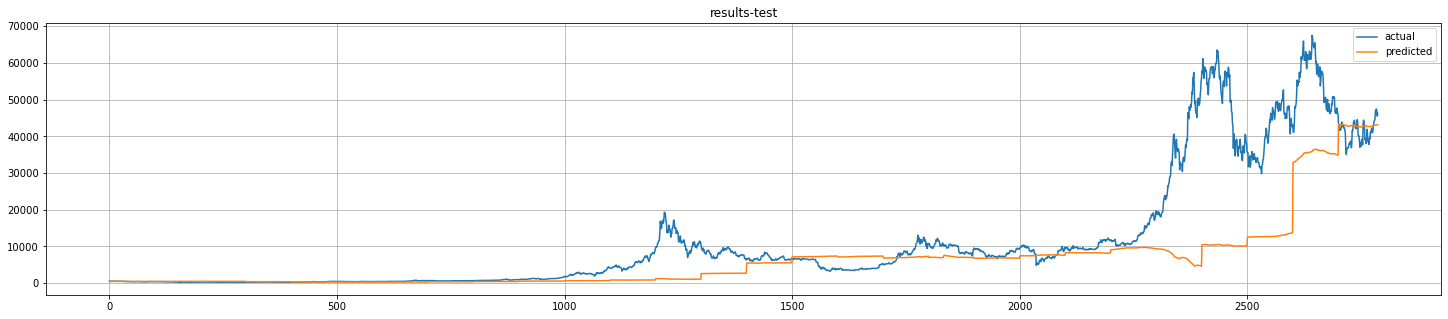

In [35]:
plot_results(lstm_y_test_array,lstm_y_test_pred_array,'results-test')

In [36]:
lstm_result_metrics_df

,batch_id,mae_train,rmse_train,mae_test,rmse_test
0,0,237.968713,275.133505,65.785547,72.505321
1,1,199.862246,251.774041,180.769140,189.599833
2,2,167.733959,217.899549,215.214953,216.066097
3,3,129.170345,158.944788,115.689002,117.790838
4,4,103.647084,144.480596,73.566779,90.324955
5,5,63.316100,84.680788,140.871750,142.639426
6,6,62.980160,81.840643,267.081930,287.342869
7,7,95.188071,121.951252,277.063114,278.666512
8,8,115.724601,142.047827,387.725470,400.515841
9,9,143.950983,174.729440,649.981945,669.705864


In [37]:
pd.DataFrame(lstm_result_metrics_df.mean()).drop(['batch_id'])

,0
mae_train,2708.633442
rmse_train,3691.850296
mae_test,5844.670405
rmse_test,6201.781755


In [38]:
lstm_result_metrics_df.to_csv('lstm_result_metrics.csv')
lstm_result_test_df.to_csv('lstm_result_test.csv')

#### Observations
1. The RMSE and MAE values obtained for the model is very high.
2. From the plot we can huge variations in the actual and predicted trend.
3. Computation is highly complex.

----

## Conclusion

1. The best and accurate model is Linear regression WRT computational time and performing better during the model evaluation. The same is shown in the plot. As the prices are gaining highs, and recovering from the sharp falls, it is advisable to invest in small amounts.  


2. The RMSE and MAE score for all the models are shown below: 
    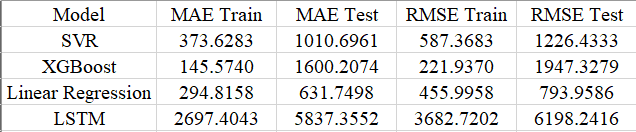
    
    
3. The least RMSE and MAE score is obtained for Linear Regression model, hence the best, accurate model.        

compute Rsquare